
# Imports

In [1]:
%matplotlib inline

In [2]:
import torch
import torchvision
import torchvision.transforms as transforms

In [3]:
import matplotlib.pyplot as plt
import numpy as np

In [4]:
!pip install torchsummary
from torchsummary import summary

In [5]:
!pip install albumentations==0.4.6

In [6]:
# Mounting to google drive
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [7]:
# Changing directory to Session 7 project folder
% cd /content/gdrive/My Drive/TSAI-EVA-7.0/07_Advanced_Concepts/

/content/gdrive/My Drive/TSAI-EVA-7.0/07_Advanced_Concepts


# Data

In [8]:
cifar_trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transforms.ToTensor())

imgs = [item[0] for item in cifar_trainset] 
labels = [item[1] for item in cifar_trainset]

imgs = torch.stack(imgs, dim=0).numpy()

mean_r = imgs[:,0,:,:].mean()
mean_g = imgs[:,1,:,:].mean()
mean_b = imgs[:,2,:,:].mean()
mu = [mean_r,mean_g,mean_b]
print(mu)

std_r = imgs[:,0,:,:].std()
std_g = imgs[:,1,:,:].std()
std_b = imgs[:,2,:,:].std()
sigma = [std_r,std_g,std_b]
print(sigma)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
[0.49139968, 0.48215827, 0.44653124]
[0.24703233, 0.24348505, 0.26158768]


## Visualization

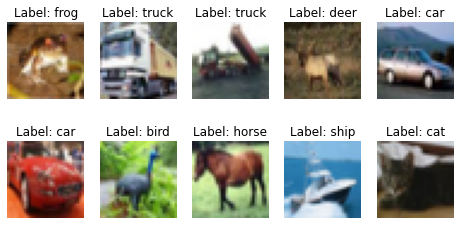

In [9]:
# functions to show an image
def plot_grid(image, label):

    nrows = 2
    ncols = 5

    fig, ax = plt.subplots(nrows, ncols, figsize=(8, 4))

    for i in range(nrows):
        for j in range(ncols):
            index = i * ncols + j
            ax[i, j].axis("off")
            ax[i, j].set_title("Label: %s" % (classes[label[index]]))
            ax[i, j].imshow(np.transpose(image[index], (1, 2, 0)))

plot_grid(imgs[0:10], labels[0:10])

In [10]:
import cv2

cv2.setNumThreads(0)
cv2.ocl.setUseOpenCL(False)

class Cifar10SearchDataset(torchvision.datasets.CIFAR10):

    def __init__(self, root="./data/cifar10", train=True, download=True, transform=None):
      super().__init__(root=root, train=train, download=download, transform=transform)

    def __getitem__(self, index):
      image, label = self.data[index], self.targets[index]
      
      if self.transform is not None:
        transformed = self.transform(image=image)
        image = transformed["image"]

        return image, label

In [11]:
from augment import augmentation

trainset = Cifar10SearchDataset(root='./data', train=True, download=True, transform=augmentation('Train', mu, sigma))
testset = Cifar10SearchDataset(root='./data', train=False, download=True, transform=augmentation('Test', mu, sigma))

Files already downloaded and verified
Files already downloaded and verified


## Dataloaders on GPU

In [12]:
class args():
    def __init__(self,device = 'cpu',use_cuda = False):
        self.batch_size = 256
        self.device = device
        self.use_cuda = use_cuda
        self.kwargs = {'num_workers': 4, 'pin_memory': True} if self.use_cuda else {}

use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print(device)

train_loader = torch.utils.data.DataLoader(trainset, batch_size=args(device, use_cuda).batch_size, shuffle=True, **args(device, use_cuda).kwargs)
test_loader = torch.utils.data.DataLoader(testset, batch_size=args(device, use_cuda).batch_size, shuffle=True, **args(device, use_cuda).kwargs)

cuda


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


# Training and testing

In [14]:
from model import Net
model = Net().to(device)
summary(model, input_size=(3, 32, 32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 32, 32]             864
       BatchNorm2d-2           [-1, 32, 32, 32]              64
              ReLU-3           [-1, 32, 32, 32]               0
            Conv2d-4           [-1, 32, 32, 32]             320
            Conv2d-5           [-1, 32, 32, 32]           1,056
depthwise_separable_conv-6           [-1, 32, 32, 32]               0
            Conv2d-7           [-1, 32, 32, 32]             320
            Conv2d-8           [-1, 32, 32, 32]           1,056
depthwise_separable_conv-9           [-1, 32, 32, 32]               0
           Conv2d-10           [-1, 32, 32, 32]             320
           Conv2d-11           [-1, 32, 32, 32]           1,056
depthwise_separable_conv-12           [-1, 32, 32, 32]               0
           Conv2d-13           [-1, 32, 16, 16]           9,216
      BatchNorm2d-14

In [15]:
import torch.optim as optim
import torch.nn as nn

EPOCHS = 1000

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.3, momentum=0.9)
scheduler = optim.lr_scheduler.OneCycleLR(optimizer, max_lr=0.05, epochs=EPOCHS, steps_per_epoch=len(train_loader))

In [16]:
from tqdm import tqdm

train_losses = []
test_losses = []
train_acc = []
test_acc = []

def train(model, device, train_loader, optimizer, epoch):
  
  model.train()
  pbar = tqdm(train_loader)
  correct = 0
  processed = 0
  train_loss = 0 

  for batch_idx, (data, target) in enumerate(pbar):

    data, target = data.to(device), target.to(device)
    optimizer.zero_grad()

    y_pred = model(data)
    loss = criterion(y_pred, target)
    train_loss += loss
    loss.backward()
    optimizer.step()
        
    pred = y_pred.argmax(dim=1, keepdim=True)  
    correct += pred.eq(target.view_as(pred)).sum().item()
    processed += len(data)

    pbar.set_description(desc= f'Loss={loss.item()} Batch_id={batch_idx} Accuracy={100*correct/processed:0.2f}')

  train_loss /= len(train_loader.dataset)
  train_losses.append(loss)
  train_acc.append(100*correct/processed)


def test(model, device, test_loader):
    
    model.eval()
    test_loss = 0
    correct = 0
    
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += criterion(output, target)
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    test_losses.append(test_loss)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))
    
    test_acc.append(100. * correct / len(test_loader.dataset))

In [17]:
for epoch in range(EPOCHS):
  
  print("EPOCH:", epoch)
  train(model, device, train_loader, optimizer, epoch)
  test(model, device, test_loader)
  scheduler.step()

  if test_acc[-1] >= 85.0: 
    break 

torch.save(model.state_dict(), './saved_models/model_weights.pth')

EPOCH: 0


  0%|          | 0/196 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
Loss=1.839435338973999 Batch_id=195 Accuracy=22.02: 100%|██████████| 196/196 [00:08<00:00, 21.86it/s]



Test set: Average loss: 0.0109, Accuracy: 1562/10000 (15.62%)

EPOCH: 1


Loss=1.8077723979949951 Batch_id=195 Accuracy=33.65: 100%|██████████| 196/196 [00:08<00:00, 22.33it/s]



Test set: Average loss: 0.0076, Accuracy: 3209/10000 (32.09%)

EPOCH: 2


Loss=1.5337564945220947 Batch_id=195 Accuracy=39.30: 100%|██████████| 196/196 [00:08<00:00, 22.32it/s]



Test set: Average loss: 0.0064, Accuracy: 4120/10000 (41.20%)

EPOCH: 3


Loss=1.4003784656524658 Batch_id=195 Accuracy=42.65: 100%|██████████| 196/196 [00:08<00:00, 22.37it/s]



Test set: Average loss: 0.0072, Accuracy: 4382/10000 (43.82%)

EPOCH: 4


Loss=1.480236530303955 Batch_id=195 Accuracy=45.08: 100%|██████████| 196/196 [00:08<00:00, 22.23it/s]



Test set: Average loss: 0.0053, Accuracy: 5180/10000 (51.80%)

EPOCH: 5


Loss=1.5006840229034424 Batch_id=195 Accuracy=46.91: 100%|██████████| 196/196 [00:08<00:00, 22.00it/s]



Test set: Average loss: 0.0057, Accuracy: 4764/10000 (47.64%)

EPOCH: 6


Loss=1.3246127367019653 Batch_id=195 Accuracy=49.29: 100%|██████████| 196/196 [00:08<00:00, 22.28it/s]



Test set: Average loss: 0.0057, Accuracy: 5179/10000 (51.79%)

EPOCH: 7


Loss=1.3223741054534912 Batch_id=195 Accuracy=50.88: 100%|██████████| 196/196 [00:08<00:00, 21.83it/s]



Test set: Average loss: 0.0051, Accuracy: 5305/10000 (53.05%)

EPOCH: 8


Loss=1.0644601583480835 Batch_id=195 Accuracy=52.78: 100%|██████████| 196/196 [00:08<00:00, 22.19it/s]



Test set: Average loss: 0.0046, Accuracy: 5986/10000 (59.86%)

EPOCH: 9


Loss=1.4936788082122803 Batch_id=195 Accuracy=53.94: 100%|██████████| 196/196 [00:08<00:00, 22.19it/s]



Test set: Average loss: 0.0051, Accuracy: 5597/10000 (55.97%)

EPOCH: 10


Loss=1.176886796951294 Batch_id=195 Accuracy=54.72: 100%|██████████| 196/196 [00:08<00:00, 22.06it/s]



Test set: Average loss: 0.0044, Accuracy: 6052/10000 (60.52%)

EPOCH: 11


Loss=1.0380442142486572 Batch_id=195 Accuracy=56.28: 100%|██████████| 196/196 [00:08<00:00, 21.98it/s]



Test set: Average loss: 0.0041, Accuracy: 6372/10000 (63.72%)

EPOCH: 12


Loss=1.3296689987182617 Batch_id=195 Accuracy=56.79: 100%|██████████| 196/196 [00:08<00:00, 22.15it/s]



Test set: Average loss: 0.0042, Accuracy: 6274/10000 (62.74%)

EPOCH: 13


Loss=1.26933753490448 Batch_id=195 Accuracy=57.64: 100%|██████████| 196/196 [00:08<00:00, 22.13it/s]



Test set: Average loss: 0.0038, Accuracy: 6726/10000 (67.26%)

EPOCH: 14


Loss=1.2710111141204834 Batch_id=195 Accuracy=58.75: 100%|██████████| 196/196 [00:08<00:00, 22.27it/s]



Test set: Average loss: 0.0038, Accuracy: 6698/10000 (66.98%)

EPOCH: 15


Loss=1.3816897869110107 Batch_id=195 Accuracy=59.03: 100%|██████████| 196/196 [00:08<00:00, 21.91it/s]



Test set: Average loss: 0.0040, Accuracy: 6607/10000 (66.07%)

EPOCH: 16


Loss=0.9920707941055298 Batch_id=195 Accuracy=59.92: 100%|██████████| 196/196 [00:08<00:00, 22.00it/s]



Test set: Average loss: 0.0038, Accuracy: 6660/10000 (66.60%)

EPOCH: 17


Loss=1.334067940711975 Batch_id=195 Accuracy=60.27: 100%|██████████| 196/196 [00:08<00:00, 22.19it/s]



Test set: Average loss: 0.0046, Accuracy: 6244/10000 (62.44%)

EPOCH: 18


Loss=1.0265926122665405 Batch_id=195 Accuracy=60.23: 100%|██████████| 196/196 [00:08<00:00, 22.30it/s]



Test set: Average loss: 0.0036, Accuracy: 6866/10000 (68.66%)

EPOCH: 19


Loss=1.2408543825149536 Batch_id=195 Accuracy=61.26: 100%|██████████| 196/196 [00:08<00:00, 22.14it/s]



Test set: Average loss: 0.0037, Accuracy: 6869/10000 (68.69%)

EPOCH: 20


Loss=1.2607896327972412 Batch_id=195 Accuracy=62.29: 100%|██████████| 196/196 [00:08<00:00, 22.32it/s]



Test set: Average loss: 0.0035, Accuracy: 6861/10000 (68.61%)

EPOCH: 21


Loss=0.989231288433075 Batch_id=195 Accuracy=61.95: 100%|██████████| 196/196 [00:08<00:00, 22.07it/s]



Test set: Average loss: 0.0034, Accuracy: 7042/10000 (70.42%)

EPOCH: 22


Loss=1.073708176612854 Batch_id=195 Accuracy=62.42: 100%|██████████| 196/196 [00:08<00:00, 21.86it/s]



Test set: Average loss: 0.0038, Accuracy: 6611/10000 (66.11%)

EPOCH: 23


Loss=1.0728809833526611 Batch_id=195 Accuracy=62.71: 100%|██████████| 196/196 [00:08<00:00, 22.11it/s]



Test set: Average loss: 0.0035, Accuracy: 6995/10000 (69.95%)

EPOCH: 24


Loss=1.1061019897460938 Batch_id=195 Accuracy=63.20: 100%|██████████| 196/196 [00:09<00:00, 21.74it/s]



Test set: Average loss: 0.0033, Accuracy: 7185/10000 (71.85%)

EPOCH: 25


Loss=0.9247156977653503 Batch_id=195 Accuracy=64.04: 100%|██████████| 196/196 [00:08<00:00, 21.95it/s]



Test set: Average loss: 0.0033, Accuracy: 7183/10000 (71.83%)

EPOCH: 26


Loss=1.0572139024734497 Batch_id=195 Accuracy=64.06: 100%|██████████| 196/196 [00:08<00:00, 21.99it/s]



Test set: Average loss: 0.0035, Accuracy: 6918/10000 (69.18%)

EPOCH: 27


Loss=0.842754065990448 Batch_id=195 Accuracy=64.12: 100%|██████████| 196/196 [00:08<00:00, 22.03it/s]



Test set: Average loss: 0.0034, Accuracy: 7160/10000 (71.60%)

EPOCH: 28


Loss=1.1962909698486328 Batch_id=195 Accuracy=64.15: 100%|██████████| 196/196 [00:08<00:00, 21.95it/s]



Test set: Average loss: 0.0031, Accuracy: 7318/10000 (73.18%)

EPOCH: 29


Loss=1.1461677551269531 Batch_id=195 Accuracy=64.32: 100%|██████████| 196/196 [00:08<00:00, 22.26it/s]



Test set: Average loss: 0.0035, Accuracy: 6989/10000 (69.89%)

EPOCH: 30


Loss=1.0112180709838867 Batch_id=195 Accuracy=64.97: 100%|██████████| 196/196 [00:08<00:00, 22.34it/s]



Test set: Average loss: 0.0029, Accuracy: 7419/10000 (74.19%)

EPOCH: 31


Loss=0.955094039440155 Batch_id=195 Accuracy=64.85: 100%|██████████| 196/196 [00:08<00:00, 22.02it/s]



Test set: Average loss: 0.0030, Accuracy: 7388/10000 (73.88%)

EPOCH: 32


Loss=0.9614050984382629 Batch_id=195 Accuracy=65.50: 100%|██████████| 196/196 [00:08<00:00, 22.35it/s]



Test set: Average loss: 0.0031, Accuracy: 7380/10000 (73.80%)

EPOCH: 33


Loss=1.0595474243164062 Batch_id=195 Accuracy=65.46: 100%|██████████| 196/196 [00:08<00:00, 22.00it/s]



Test set: Average loss: 0.0031, Accuracy: 7307/10000 (73.07%)

EPOCH: 34


Loss=0.8915170431137085 Batch_id=195 Accuracy=65.53: 100%|██████████| 196/196 [00:08<00:00, 21.78it/s]



Test set: Average loss: 0.0031, Accuracy: 7285/10000 (72.85%)

EPOCH: 35


Loss=0.9779051542282104 Batch_id=195 Accuracy=65.91: 100%|██████████| 196/196 [00:09<00:00, 21.44it/s]



Test set: Average loss: 0.0028, Accuracy: 7506/10000 (75.06%)

EPOCH: 36


Loss=0.8548955917358398 Batch_id=195 Accuracy=66.31: 100%|██████████| 196/196 [00:09<00:00, 21.22it/s]



Test set: Average loss: 0.0030, Accuracy: 7448/10000 (74.48%)

EPOCH: 37


Loss=1.2636046409606934 Batch_id=195 Accuracy=66.14: 100%|██████████| 196/196 [00:08<00:00, 22.00it/s]



Test set: Average loss: 0.0033, Accuracy: 7295/10000 (72.95%)

EPOCH: 38


Loss=0.9999282956123352 Batch_id=195 Accuracy=66.32: 100%|██████████| 196/196 [00:08<00:00, 22.23it/s]



Test set: Average loss: 0.0029, Accuracy: 7518/10000 (75.18%)

EPOCH: 39


Loss=0.9649379849433899 Batch_id=195 Accuracy=66.52: 100%|██████████| 196/196 [00:08<00:00, 21.96it/s]



Test set: Average loss: 0.0029, Accuracy: 7427/10000 (74.27%)

EPOCH: 40


Loss=1.064299464225769 Batch_id=195 Accuracy=67.00: 100%|██████████| 196/196 [00:08<00:00, 22.03it/s]



Test set: Average loss: 0.0032, Accuracy: 7311/10000 (73.11%)

EPOCH: 41


Loss=0.9878053665161133 Batch_id=195 Accuracy=66.97: 100%|██████████| 196/196 [00:08<00:00, 21.88it/s]



Test set: Average loss: 0.0033, Accuracy: 7242/10000 (72.42%)

EPOCH: 42


Loss=0.7969251275062561 Batch_id=195 Accuracy=67.16: 100%|██████████| 196/196 [00:08<00:00, 21.87it/s]



Test set: Average loss: 0.0032, Accuracy: 7307/10000 (73.07%)

EPOCH: 43


Loss=0.8311047554016113 Batch_id=195 Accuracy=66.97: 100%|██████████| 196/196 [00:08<00:00, 22.00it/s]



Test set: Average loss: 0.0030, Accuracy: 7382/10000 (73.82%)

EPOCH: 44


Loss=0.9742973446846008 Batch_id=195 Accuracy=67.45: 100%|██████████| 196/196 [00:08<00:00, 21.96it/s]



Test set: Average loss: 0.0029, Accuracy: 7541/10000 (75.41%)

EPOCH: 45


Loss=0.8890268206596375 Batch_id=195 Accuracy=68.02: 100%|██████████| 196/196 [00:08<00:00, 21.83it/s]



Test set: Average loss: 0.0033, Accuracy: 7201/10000 (72.01%)

EPOCH: 46


Loss=1.031642198562622 Batch_id=195 Accuracy=67.72: 100%|██████████| 196/196 [00:08<00:00, 21.98it/s]



Test set: Average loss: 0.0026, Accuracy: 7713/10000 (77.13%)

EPOCH: 47


Loss=0.8818596005439758 Batch_id=195 Accuracy=67.75: 100%|██████████| 196/196 [00:08<00:00, 21.96it/s]



Test set: Average loss: 0.0027, Accuracy: 7680/10000 (76.80%)

EPOCH: 48


Loss=0.9754766225814819 Batch_id=195 Accuracy=68.06: 100%|██████████| 196/196 [00:09<00:00, 21.59it/s]



Test set: Average loss: 0.0032, Accuracy: 7274/10000 (72.74%)

EPOCH: 49


Loss=1.230767011642456 Batch_id=195 Accuracy=68.30: 100%|██████████| 196/196 [00:08<00:00, 21.83it/s]



Test set: Average loss: 0.0026, Accuracy: 7732/10000 (77.32%)

EPOCH: 50


Loss=0.8622384071350098 Batch_id=195 Accuracy=67.95: 100%|██████████| 196/196 [00:09<00:00, 21.78it/s]



Test set: Average loss: 0.0029, Accuracy: 7454/10000 (74.54%)

EPOCH: 51


Loss=0.9996808171272278 Batch_id=195 Accuracy=68.15: 100%|██████████| 196/196 [00:09<00:00, 21.64it/s]



Test set: Average loss: 0.0028, Accuracy: 7724/10000 (77.24%)

EPOCH: 52


Loss=0.8242338299751282 Batch_id=195 Accuracy=68.61: 100%|██████████| 196/196 [00:08<00:00, 22.10it/s]



Test set: Average loss: 0.0027, Accuracy: 7646/10000 (76.46%)

EPOCH: 53


Loss=0.7845126390457153 Batch_id=195 Accuracy=68.30: 100%|██████████| 196/196 [00:08<00:00, 22.03it/s]



Test set: Average loss: 0.0029, Accuracy: 7573/10000 (75.73%)

EPOCH: 54


Loss=1.0198726654052734 Batch_id=195 Accuracy=68.87: 100%|██████████| 196/196 [00:09<00:00, 21.73it/s]



Test set: Average loss: 0.0026, Accuracy: 7725/10000 (77.25%)

EPOCH: 55


Loss=0.790810227394104 Batch_id=195 Accuracy=69.08: 100%|██████████| 196/196 [00:08<00:00, 21.94it/s]



Test set: Average loss: 0.0026, Accuracy: 7740/10000 (77.40%)

EPOCH: 56


Loss=0.8489354848861694 Batch_id=195 Accuracy=68.87: 100%|██████████| 196/196 [00:09<00:00, 21.77it/s]



Test set: Average loss: 0.0028, Accuracy: 7552/10000 (75.52%)

EPOCH: 57


Loss=0.9866935014724731 Batch_id=195 Accuracy=69.04: 100%|██████████| 196/196 [00:09<00:00, 21.19it/s]



Test set: Average loss: 0.0029, Accuracy: 7608/10000 (76.08%)

EPOCH: 58


Loss=0.8782297372817993 Batch_id=195 Accuracy=69.04: 100%|██████████| 196/196 [00:09<00:00, 21.72it/s]



Test set: Average loss: 0.0025, Accuracy: 7889/10000 (78.89%)

EPOCH: 59


Loss=1.176125407218933 Batch_id=195 Accuracy=69.12: 100%|██████████| 196/196 [00:09<00:00, 21.15it/s]



Test set: Average loss: 0.0027, Accuracy: 7765/10000 (77.65%)

EPOCH: 60


Loss=0.6945206522941589 Batch_id=195 Accuracy=69.57: 100%|██████████| 196/196 [00:09<00:00, 21.32it/s]



Test set: Average loss: 0.0024, Accuracy: 7906/10000 (79.06%)

EPOCH: 61


Loss=0.7151599526405334 Batch_id=195 Accuracy=69.67: 100%|██████████| 196/196 [00:09<00:00, 21.00it/s]



Test set: Average loss: 0.0026, Accuracy: 7810/10000 (78.10%)

EPOCH: 62


Loss=0.8469439744949341 Batch_id=195 Accuracy=69.32: 100%|██████████| 196/196 [00:09<00:00, 20.98it/s]



Test set: Average loss: 0.0025, Accuracy: 7860/10000 (78.60%)

EPOCH: 63


Loss=0.7607933878898621 Batch_id=195 Accuracy=69.50: 100%|██████████| 196/196 [00:09<00:00, 21.75it/s]



Test set: Average loss: 0.0027, Accuracy: 7803/10000 (78.03%)

EPOCH: 64


Loss=0.9191522598266602 Batch_id=195 Accuracy=69.46: 100%|██████████| 196/196 [00:09<00:00, 21.72it/s]



Test set: Average loss: 0.0027, Accuracy: 7727/10000 (77.27%)

EPOCH: 65


Loss=0.9990307092666626 Batch_id=195 Accuracy=69.82: 100%|██████████| 196/196 [00:08<00:00, 21.85it/s]



Test set: Average loss: 0.0029, Accuracy: 7558/10000 (75.58%)

EPOCH: 66


Loss=0.8556705713272095 Batch_id=195 Accuracy=70.03: 100%|██████████| 196/196 [00:09<00:00, 21.40it/s]



Test set: Average loss: 0.0025, Accuracy: 7845/10000 (78.45%)

EPOCH: 67


Loss=0.814306914806366 Batch_id=195 Accuracy=69.90: 100%|██████████| 196/196 [00:09<00:00, 21.17it/s]



Test set: Average loss: 0.0023, Accuracy: 8045/10000 (80.45%)

EPOCH: 68


Loss=0.8601753115653992 Batch_id=195 Accuracy=69.79: 100%|██████████| 196/196 [00:09<00:00, 21.67it/s]



Test set: Average loss: 0.0024, Accuracy: 7897/10000 (78.97%)

EPOCH: 69


Loss=0.7726128101348877 Batch_id=195 Accuracy=70.31: 100%|██████████| 196/196 [00:09<00:00, 21.47it/s]



Test set: Average loss: 0.0024, Accuracy: 7948/10000 (79.48%)

EPOCH: 70


Loss=1.0525329113006592 Batch_id=195 Accuracy=70.31: 100%|██████████| 196/196 [00:09<00:00, 21.78it/s]



Test set: Average loss: 0.0025, Accuracy: 7877/10000 (78.77%)

EPOCH: 71


Loss=0.93207186460495 Batch_id=195 Accuracy=70.36: 100%|██████████| 196/196 [00:09<00:00, 21.65it/s]



Test set: Average loss: 0.0025, Accuracy: 7936/10000 (79.36%)

EPOCH: 72


Loss=1.0181046724319458 Batch_id=195 Accuracy=69.85: 100%|██████████| 196/196 [00:09<00:00, 21.72it/s]



Test set: Average loss: 0.0024, Accuracy: 7988/10000 (79.88%)

EPOCH: 73


Loss=0.834027111530304 Batch_id=195 Accuracy=70.94: 100%|██████████| 196/196 [00:09<00:00, 21.62it/s]



Test set: Average loss: 0.0024, Accuracy: 7920/10000 (79.20%)

EPOCH: 74


Loss=0.7279177904129028 Batch_id=195 Accuracy=70.72: 100%|██████████| 196/196 [00:09<00:00, 21.65it/s]



Test set: Average loss: 0.0023, Accuracy: 8011/10000 (80.11%)

EPOCH: 75


Loss=0.8394988775253296 Batch_id=195 Accuracy=70.40: 100%|██████████| 196/196 [00:09<00:00, 21.49it/s]



Test set: Average loss: 0.0025, Accuracy: 7833/10000 (78.33%)

EPOCH: 76


Loss=0.9288395047187805 Batch_id=195 Accuracy=70.72: 100%|██████████| 196/196 [00:09<00:00, 21.62it/s]



Test set: Average loss: 0.0023, Accuracy: 7963/10000 (79.63%)

EPOCH: 77


Loss=0.8471218347549438 Batch_id=195 Accuracy=71.05: 100%|██████████| 196/196 [00:09<00:00, 21.31it/s]



Test set: Average loss: 0.0023, Accuracy: 8032/10000 (80.32%)

EPOCH: 78


Loss=0.9068179130554199 Batch_id=195 Accuracy=70.79: 100%|██████████| 196/196 [00:09<00:00, 21.68it/s]



Test set: Average loss: 0.0023, Accuracy: 7990/10000 (79.90%)

EPOCH: 79


Loss=0.803658664226532 Batch_id=195 Accuracy=71.09: 100%|██████████| 196/196 [00:09<00:00, 21.74it/s]



Test set: Average loss: 0.0024, Accuracy: 7913/10000 (79.13%)

EPOCH: 80


Loss=1.0083951950073242 Batch_id=195 Accuracy=71.17: 100%|██████████| 196/196 [00:09<00:00, 21.50it/s]



Test set: Average loss: 0.0025, Accuracy: 7903/10000 (79.03%)

EPOCH: 81


Loss=0.9463275074958801 Batch_id=195 Accuracy=71.13: 100%|██████████| 196/196 [00:09<00:00, 21.57it/s]



Test set: Average loss: 0.0023, Accuracy: 8018/10000 (80.18%)

EPOCH: 82


Loss=0.7127051949501038 Batch_id=195 Accuracy=71.30: 100%|██████████| 196/196 [00:08<00:00, 21.87it/s]



Test set: Average loss: 0.0024, Accuracy: 7949/10000 (79.49%)

EPOCH: 83


Loss=1.0794165134429932 Batch_id=195 Accuracy=70.93: 100%|██████████| 196/196 [00:09<00:00, 21.73it/s]



Test set: Average loss: 0.0024, Accuracy: 7941/10000 (79.41%)

EPOCH: 84


Loss=0.770541250705719 Batch_id=195 Accuracy=71.27: 100%|██████████| 196/196 [00:09<00:00, 21.21it/s]



Test set: Average loss: 0.0023, Accuracy: 8037/10000 (80.37%)

EPOCH: 85


Loss=0.7036237716674805 Batch_id=195 Accuracy=71.14: 100%|██████████| 196/196 [00:08<00:00, 21.79it/s]



Test set: Average loss: 0.0023, Accuracy: 8027/10000 (80.27%)

EPOCH: 86


Loss=0.7357228994369507 Batch_id=195 Accuracy=71.45: 100%|██████████| 196/196 [00:09<00:00, 21.67it/s]



Test set: Average loss: 0.0026, Accuracy: 7810/10000 (78.10%)

EPOCH: 87


Loss=0.6468073129653931 Batch_id=195 Accuracy=71.29: 100%|██████████| 196/196 [00:09<00:00, 21.37it/s]



Test set: Average loss: 0.0023, Accuracy: 8016/10000 (80.16%)

EPOCH: 88


Loss=0.7660249471664429 Batch_id=195 Accuracy=71.38: 100%|██████████| 196/196 [00:09<00:00, 21.69it/s]



Test set: Average loss: 0.0022, Accuracy: 8097/10000 (80.97%)

EPOCH: 89


Loss=0.8942064046859741 Batch_id=195 Accuracy=71.53: 100%|██████████| 196/196 [00:09<00:00, 21.63it/s]



Test set: Average loss: 0.0022, Accuracy: 8053/10000 (80.53%)

EPOCH: 90


Loss=0.7719824314117432 Batch_id=195 Accuracy=71.49: 100%|██████████| 196/196 [00:09<00:00, 21.48it/s]



Test set: Average loss: 0.0023, Accuracy: 8070/10000 (80.70%)

EPOCH: 91


Loss=0.8273633718490601 Batch_id=195 Accuracy=71.51: 100%|██████████| 196/196 [00:08<00:00, 21.85it/s]



Test set: Average loss: 0.0024, Accuracy: 8050/10000 (80.50%)

EPOCH: 92


Loss=0.6711041927337646 Batch_id=195 Accuracy=72.13: 100%|██████████| 196/196 [00:09<00:00, 21.64it/s]



Test set: Average loss: 0.0023, Accuracy: 8058/10000 (80.58%)

EPOCH: 93


Loss=0.8625888824462891 Batch_id=195 Accuracy=71.76: 100%|██████████| 196/196 [00:09<00:00, 21.44it/s]



Test set: Average loss: 0.0023, Accuracy: 8047/10000 (80.47%)

EPOCH: 94


Loss=1.020964503288269 Batch_id=195 Accuracy=71.73: 100%|██████████| 196/196 [00:09<00:00, 21.44it/s]



Test set: Average loss: 0.0023, Accuracy: 8044/10000 (80.44%)

EPOCH: 95


Loss=1.1973979473114014 Batch_id=195 Accuracy=71.95: 100%|██████████| 196/196 [00:09<00:00, 21.74it/s]



Test set: Average loss: 0.0022, Accuracy: 8106/10000 (81.06%)

EPOCH: 96


Loss=0.7957553863525391 Batch_id=195 Accuracy=71.90: 100%|██████████| 196/196 [00:09<00:00, 21.58it/s]



Test set: Average loss: 0.0022, Accuracy: 8153/10000 (81.53%)

EPOCH: 97


Loss=0.7275228500366211 Batch_id=195 Accuracy=72.11: 100%|██████████| 196/196 [00:09<00:00, 21.31it/s]



Test set: Average loss: 0.0022, Accuracy: 8127/10000 (81.27%)

EPOCH: 98


Loss=0.7793901562690735 Batch_id=195 Accuracy=72.23: 100%|██████████| 196/196 [00:09<00:00, 21.30it/s]



Test set: Average loss: 0.0022, Accuracy: 8081/10000 (80.81%)

EPOCH: 99


Loss=0.6149958968162537 Batch_id=195 Accuracy=72.25: 100%|██████████| 196/196 [00:09<00:00, 21.48it/s]



Test set: Average loss: 0.0026, Accuracy: 7908/10000 (79.08%)

EPOCH: 100


Loss=1.2264047861099243 Batch_id=195 Accuracy=71.89: 100%|██████████| 196/196 [00:09<00:00, 21.55it/s]



Test set: Average loss: 0.0021, Accuracy: 8123/10000 (81.23%)

EPOCH: 101


Loss=0.6978756189346313 Batch_id=195 Accuracy=72.25: 100%|██████████| 196/196 [00:09<00:00, 21.53it/s]



Test set: Average loss: 0.0023, Accuracy: 8035/10000 (80.35%)

EPOCH: 102


Loss=0.9439758062362671 Batch_id=195 Accuracy=72.25: 100%|██████████| 196/196 [00:09<00:00, 21.75it/s]



Test set: Average loss: 0.0026, Accuracy: 7845/10000 (78.45%)

EPOCH: 103


Loss=0.7028055787086487 Batch_id=195 Accuracy=71.95: 100%|██████████| 196/196 [00:09<00:00, 21.72it/s]



Test set: Average loss: 0.0022, Accuracy: 8142/10000 (81.42%)

EPOCH: 104


Loss=0.9068376421928406 Batch_id=195 Accuracy=72.15: 100%|██████████| 196/196 [00:09<00:00, 21.44it/s]



Test set: Average loss: 0.0022, Accuracy: 8144/10000 (81.44%)

EPOCH: 105


Loss=0.6088979840278625 Batch_id=195 Accuracy=72.68: 100%|██████████| 196/196 [00:09<00:00, 21.24it/s]



Test set: Average loss: 0.0023, Accuracy: 8032/10000 (80.32%)

EPOCH: 106


Loss=0.8065311312675476 Batch_id=195 Accuracy=72.43: 100%|██████████| 196/196 [00:09<00:00, 21.28it/s]



Test set: Average loss: 0.0023, Accuracy: 8020/10000 (80.20%)

EPOCH: 107


Loss=0.7167264819145203 Batch_id=195 Accuracy=72.39: 100%|██████████| 196/196 [00:09<00:00, 21.28it/s]



Test set: Average loss: 0.0022, Accuracy: 8061/10000 (80.61%)

EPOCH: 108


Loss=0.8691339492797852 Batch_id=195 Accuracy=72.72: 100%|██████████| 196/196 [00:09<00:00, 21.58it/s]



Test set: Average loss: 0.0022, Accuracy: 8163/10000 (81.63%)

EPOCH: 109


Loss=1.1508194208145142 Batch_id=195 Accuracy=72.54: 100%|██████████| 196/196 [00:09<00:00, 21.44it/s]



Test set: Average loss: 0.0023, Accuracy: 8070/10000 (80.70%)

EPOCH: 110


Loss=0.8001917600631714 Batch_id=195 Accuracy=72.50: 100%|██████████| 196/196 [00:09<00:00, 21.47it/s]



Test set: Average loss: 0.0022, Accuracy: 8095/10000 (80.95%)

EPOCH: 111


Loss=0.8313288688659668 Batch_id=195 Accuracy=72.62: 100%|██████████| 196/196 [00:09<00:00, 21.40it/s]



Test set: Average loss: 0.0022, Accuracy: 8130/10000 (81.30%)

EPOCH: 112


Loss=0.7130874991416931 Batch_id=195 Accuracy=72.67: 100%|██████████| 196/196 [00:09<00:00, 21.36it/s]



Test set: Average loss: 0.0021, Accuracy: 8209/10000 (82.09%)

EPOCH: 113


Loss=0.873981773853302 Batch_id=195 Accuracy=72.58: 100%|██████████| 196/196 [00:09<00:00, 21.50it/s]



Test set: Average loss: 0.0021, Accuracy: 8220/10000 (82.20%)

EPOCH: 114


Loss=0.6139246225357056 Batch_id=195 Accuracy=72.80: 100%|██████████| 196/196 [00:09<00:00, 21.35it/s]



Test set: Average loss: 0.0022, Accuracy: 8142/10000 (81.42%)

EPOCH: 115


Loss=0.6070355176925659 Batch_id=195 Accuracy=72.85: 100%|██████████| 196/196 [00:09<00:00, 21.40it/s]



Test set: Average loss: 0.0021, Accuracy: 8211/10000 (82.11%)

EPOCH: 116


Loss=0.9208992719650269 Batch_id=195 Accuracy=72.80: 100%|██████████| 196/196 [00:09<00:00, 21.38it/s]



Test set: Average loss: 0.0023, Accuracy: 8101/10000 (81.01%)

EPOCH: 117


Loss=1.0560166835784912 Batch_id=195 Accuracy=73.05: 100%|██████████| 196/196 [00:09<00:00, 21.10it/s]



Test set: Average loss: 0.0022, Accuracy: 8125/10000 (81.25%)

EPOCH: 118


Loss=1.0405049324035645 Batch_id=195 Accuracy=72.85: 100%|██████████| 196/196 [00:09<00:00, 21.39it/s]



Test set: Average loss: 0.0025, Accuracy: 7988/10000 (79.88%)

EPOCH: 119


Loss=0.5674425959587097 Batch_id=195 Accuracy=73.00: 100%|██████████| 196/196 [00:09<00:00, 21.46it/s]



Test set: Average loss: 0.0021, Accuracy: 8224/10000 (82.24%)

EPOCH: 120


Loss=0.9166743159294128 Batch_id=195 Accuracy=73.13: 100%|██████████| 196/196 [00:09<00:00, 21.20it/s]



Test set: Average loss: 0.0022, Accuracy: 8092/10000 (80.92%)

EPOCH: 121


Loss=0.6500520706176758 Batch_id=195 Accuracy=73.23: 100%|██████████| 196/196 [00:09<00:00, 21.24it/s]



Test set: Average loss: 0.0021, Accuracy: 8196/10000 (81.96%)

EPOCH: 122


Loss=0.7299973368644714 Batch_id=195 Accuracy=73.21: 100%|██████████| 196/196 [00:09<00:00, 21.43it/s]



Test set: Average loss: 0.0022, Accuracy: 8120/10000 (81.20%)

EPOCH: 123


Loss=0.8173373341560364 Batch_id=195 Accuracy=73.25: 100%|██████████| 196/196 [00:09<00:00, 21.37it/s]



Test set: Average loss: 0.0021, Accuracy: 8195/10000 (81.95%)

EPOCH: 124


Loss=0.9731867909431458 Batch_id=195 Accuracy=73.47: 100%|██████████| 196/196 [00:09<00:00, 21.45it/s]



Test set: Average loss: 0.0021, Accuracy: 8163/10000 (81.63%)

EPOCH: 125


Loss=0.693658709526062 Batch_id=195 Accuracy=73.29: 100%|██████████| 196/196 [00:09<00:00, 21.57it/s]



Test set: Average loss: 0.0021, Accuracy: 8269/10000 (82.69%)

EPOCH: 126


Loss=0.8211970329284668 Batch_id=195 Accuracy=73.13: 100%|██████████| 196/196 [00:09<00:00, 21.38it/s]



Test set: Average loss: 0.0020, Accuracy: 8297/10000 (82.97%)

EPOCH: 127


Loss=0.7161243557929993 Batch_id=195 Accuracy=73.44: 100%|██████████| 196/196 [00:09<00:00, 21.42it/s]



Test set: Average loss: 0.0021, Accuracy: 8252/10000 (82.52%)

EPOCH: 128


Loss=0.8492143750190735 Batch_id=195 Accuracy=73.43: 100%|██████████| 196/196 [00:09<00:00, 21.47it/s]



Test set: Average loss: 0.0022, Accuracy: 8115/10000 (81.15%)

EPOCH: 129


Loss=0.8978942632675171 Batch_id=195 Accuracy=73.32: 100%|██████████| 196/196 [00:09<00:00, 21.15it/s]



Test set: Average loss: 0.0022, Accuracy: 8149/10000 (81.49%)

EPOCH: 130


Loss=0.7817467451095581 Batch_id=195 Accuracy=73.30: 100%|██████████| 196/196 [00:09<00:00, 21.23it/s]



Test set: Average loss: 0.0020, Accuracy: 8296/10000 (82.96%)

EPOCH: 131


Loss=0.6455178260803223 Batch_id=195 Accuracy=73.21: 100%|██████████| 196/196 [00:09<00:00, 21.51it/s]



Test set: Average loss: 0.0021, Accuracy: 8233/10000 (82.33%)

EPOCH: 132


Loss=0.6051408052444458 Batch_id=195 Accuracy=73.57: 100%|██████████| 196/196 [00:09<00:00, 21.66it/s]



Test set: Average loss: 0.0021, Accuracy: 8234/10000 (82.34%)

EPOCH: 133


Loss=0.8223055005073547 Batch_id=195 Accuracy=73.78: 100%|██████████| 196/196 [00:09<00:00, 21.31it/s]



Test set: Average loss: 0.0021, Accuracy: 8203/10000 (82.03%)

EPOCH: 134


Loss=0.8159526586532593 Batch_id=195 Accuracy=73.77: 100%|██████████| 196/196 [00:09<00:00, 21.57it/s]



Test set: Average loss: 0.0021, Accuracy: 8217/10000 (82.17%)

EPOCH: 135


Loss=0.8075544238090515 Batch_id=195 Accuracy=73.96: 100%|██████████| 196/196 [00:09<00:00, 21.32it/s]



Test set: Average loss: 0.0021, Accuracy: 8178/10000 (81.78%)

EPOCH: 136


Loss=0.8619105219841003 Batch_id=195 Accuracy=73.78: 100%|██████████| 196/196 [00:09<00:00, 21.34it/s]



Test set: Average loss: 0.0023, Accuracy: 8108/10000 (81.08%)

EPOCH: 137


Loss=0.5806077718734741 Batch_id=195 Accuracy=73.84: 100%|██████████| 196/196 [00:09<00:00, 21.22it/s]



Test set: Average loss: 0.0021, Accuracy: 8228/10000 (82.28%)

EPOCH: 138


Loss=0.7367845177650452 Batch_id=195 Accuracy=73.82: 100%|██████████| 196/196 [00:09<00:00, 21.33it/s]



Test set: Average loss: 0.0020, Accuracy: 8272/10000 (82.72%)

EPOCH: 139


Loss=0.7797610759735107 Batch_id=195 Accuracy=74.03: 100%|██████████| 196/196 [00:09<00:00, 21.51it/s]



Test set: Average loss: 0.0021, Accuracy: 8203/10000 (82.03%)

EPOCH: 140


Loss=0.8943036794662476 Batch_id=195 Accuracy=73.75: 100%|██████████| 196/196 [00:09<00:00, 21.35it/s]



Test set: Average loss: 0.0020, Accuracy: 8258/10000 (82.58%)

EPOCH: 141


Loss=0.7840172648429871 Batch_id=195 Accuracy=73.73: 100%|██████████| 196/196 [00:09<00:00, 21.44it/s]



Test set: Average loss: 0.0021, Accuracy: 8156/10000 (81.56%)

EPOCH: 142


Loss=0.7285860776901245 Batch_id=195 Accuracy=73.92: 100%|██████████| 196/196 [00:09<00:00, 21.40it/s]



Test set: Average loss: 0.0020, Accuracy: 8283/10000 (82.83%)

EPOCH: 143


Loss=0.9401798248291016 Batch_id=195 Accuracy=74.11: 100%|██████████| 196/196 [00:09<00:00, 21.20it/s]



Test set: Average loss: 0.0021, Accuracy: 8180/10000 (81.80%)

EPOCH: 144


Loss=0.6853905916213989 Batch_id=195 Accuracy=74.02: 100%|██████████| 196/196 [00:09<00:00, 21.26it/s]



Test set: Average loss: 0.0021, Accuracy: 8217/10000 (82.17%)

EPOCH: 145


Loss=0.7771384716033936 Batch_id=195 Accuracy=73.87: 100%|██████████| 196/196 [00:09<00:00, 21.26it/s]



Test set: Average loss: 0.0020, Accuracy: 8226/10000 (82.26%)

EPOCH: 146


Loss=0.6660754084587097 Batch_id=195 Accuracy=73.99: 100%|██████████| 196/196 [00:09<00:00, 21.04it/s]



Test set: Average loss: 0.0019, Accuracy: 8311/10000 (83.11%)

EPOCH: 147


Loss=0.563872218132019 Batch_id=195 Accuracy=73.91: 100%|██████████| 196/196 [00:09<00:00, 21.05it/s]



Test set: Average loss: 0.0020, Accuracy: 8258/10000 (82.58%)

EPOCH: 148


Loss=0.7369681596755981 Batch_id=195 Accuracy=74.36: 100%|██████████| 196/196 [00:09<00:00, 21.40it/s]



Test set: Average loss: 0.0021, Accuracy: 8205/10000 (82.05%)

EPOCH: 149


Loss=0.7936651110649109 Batch_id=195 Accuracy=73.93: 100%|██████████| 196/196 [00:09<00:00, 21.17it/s]



Test set: Average loss: 0.0020, Accuracy: 8249/10000 (82.49%)

EPOCH: 150


Loss=0.5422139167785645 Batch_id=195 Accuracy=73.92: 100%|██████████| 196/196 [00:09<00:00, 21.41it/s]



Test set: Average loss: 0.0019, Accuracy: 8381/10000 (83.81%)

EPOCH: 151


Loss=0.889090895652771 Batch_id=195 Accuracy=74.36: 100%|██████████| 196/196 [00:09<00:00, 21.32it/s]



Test set: Average loss: 0.0020, Accuracy: 8252/10000 (82.52%)

EPOCH: 152


Loss=0.8349830508232117 Batch_id=195 Accuracy=73.99: 100%|██████████| 196/196 [00:09<00:00, 21.23it/s]



Test set: Average loss: 0.0021, Accuracy: 8180/10000 (81.80%)

EPOCH: 153


Loss=0.7410386204719543 Batch_id=195 Accuracy=74.23: 100%|██████████| 196/196 [00:09<00:00, 21.13it/s]



Test set: Average loss: 0.0022, Accuracy: 8147/10000 (81.47%)

EPOCH: 154


Loss=0.6053060293197632 Batch_id=195 Accuracy=74.25: 100%|██████████| 196/196 [00:09<00:00, 21.04it/s]



Test set: Average loss: 0.0021, Accuracy: 8193/10000 (81.93%)

EPOCH: 155


Loss=0.7531468868255615 Batch_id=195 Accuracy=74.23: 100%|██████████| 196/196 [00:09<00:00, 21.31it/s]



Test set: Average loss: 0.0020, Accuracy: 8331/10000 (83.31%)

EPOCH: 156


Loss=0.7357544898986816 Batch_id=195 Accuracy=74.34: 100%|██████████| 196/196 [00:09<00:00, 21.15it/s]



Test set: Average loss: 0.0020, Accuracy: 8278/10000 (82.78%)

EPOCH: 157


Loss=0.6059499382972717 Batch_id=195 Accuracy=74.53: 100%|██████████| 196/196 [00:09<00:00, 21.16it/s]



Test set: Average loss: 0.0020, Accuracy: 8227/10000 (82.27%)

EPOCH: 158


Loss=0.5496143102645874 Batch_id=195 Accuracy=74.76: 100%|██████████| 196/196 [00:09<00:00, 21.04it/s]



Test set: Average loss: 0.0019, Accuracy: 8323/10000 (83.23%)

EPOCH: 159


Loss=0.8183799982070923 Batch_id=195 Accuracy=74.39: 100%|██████████| 196/196 [00:09<00:00, 21.10it/s]



Test set: Average loss: 0.0021, Accuracy: 8231/10000 (82.31%)

EPOCH: 160


Loss=0.8369987607002258 Batch_id=195 Accuracy=74.46: 100%|██████████| 196/196 [00:09<00:00, 21.25it/s]



Test set: Average loss: 0.0021, Accuracy: 8272/10000 (82.72%)

EPOCH: 161


Loss=0.6063839197158813 Batch_id=195 Accuracy=74.30: 100%|██████████| 196/196 [00:09<00:00, 21.18it/s]



Test set: Average loss: 0.0020, Accuracy: 8373/10000 (83.73%)

EPOCH: 162


Loss=0.7796372175216675 Batch_id=195 Accuracy=74.40: 100%|██████████| 196/196 [00:09<00:00, 21.16it/s]



Test set: Average loss: 0.0019, Accuracy: 8325/10000 (83.25%)

EPOCH: 163


Loss=0.7876496315002441 Batch_id=195 Accuracy=74.37: 100%|██████████| 196/196 [00:09<00:00, 21.23it/s]



Test set: Average loss: 0.0019, Accuracy: 8363/10000 (83.63%)

EPOCH: 164


Loss=0.8979611396789551 Batch_id=195 Accuracy=74.07: 100%|██████████| 196/196 [00:09<00:00, 21.32it/s]



Test set: Average loss: 0.0020, Accuracy: 8260/10000 (82.60%)

EPOCH: 165


Loss=1.0111539363861084 Batch_id=195 Accuracy=74.56: 100%|██████████| 196/196 [00:09<00:00, 21.09it/s]



Test set: Average loss: 0.0020, Accuracy: 8294/10000 (82.94%)

EPOCH: 166


Loss=0.7423443794250488 Batch_id=195 Accuracy=74.77: 100%|██████████| 196/196 [00:09<00:00, 21.50it/s]



Test set: Average loss: 0.0020, Accuracy: 8262/10000 (82.62%)

EPOCH: 167


Loss=0.688293993473053 Batch_id=195 Accuracy=74.69: 100%|██████████| 196/196 [00:09<00:00, 21.22it/s]



Test set: Average loss: 0.0020, Accuracy: 8276/10000 (82.76%)

EPOCH: 168


Loss=0.6783198714256287 Batch_id=195 Accuracy=75.07: 100%|██████████| 196/196 [00:09<00:00, 21.31it/s]



Test set: Average loss: 0.0020, Accuracy: 8251/10000 (82.51%)

EPOCH: 169


Loss=0.715957760810852 Batch_id=195 Accuracy=75.06: 100%|██████████| 196/196 [00:09<00:00, 20.98it/s]



Test set: Average loss: 0.0020, Accuracy: 8255/10000 (82.55%)

EPOCH: 170


Loss=0.8670526742935181 Batch_id=195 Accuracy=74.47: 100%|██████████| 196/196 [00:09<00:00, 21.15it/s]



Test set: Average loss: 0.0020, Accuracy: 8300/10000 (83.00%)

EPOCH: 171


Loss=0.5373364686965942 Batch_id=195 Accuracy=74.98: 100%|██████████| 196/196 [00:09<00:00, 21.22it/s]



Test set: Average loss: 0.0020, Accuracy: 8314/10000 (83.14%)

EPOCH: 172


Loss=0.848824143409729 Batch_id=195 Accuracy=74.82: 100%|██████████| 196/196 [00:09<00:00, 20.92it/s]



Test set: Average loss: 0.0020, Accuracy: 8341/10000 (83.41%)

EPOCH: 173


Loss=0.6592997312545776 Batch_id=195 Accuracy=75.07: 100%|██████████| 196/196 [00:09<00:00, 21.29it/s]



Test set: Average loss: 0.0019, Accuracy: 8319/10000 (83.19%)

EPOCH: 174


Loss=0.6064094305038452 Batch_id=195 Accuracy=74.73: 100%|██████████| 196/196 [00:09<00:00, 21.05it/s]



Test set: Average loss: 0.0019, Accuracy: 8341/10000 (83.41%)

EPOCH: 175


Loss=0.7901880741119385 Batch_id=195 Accuracy=74.80: 100%|██████████| 196/196 [00:09<00:00, 20.90it/s]



Test set: Average loss: 0.0018, Accuracy: 8422/10000 (84.22%)

EPOCH: 176


Loss=0.6084073781967163 Batch_id=195 Accuracy=74.89: 100%|██████████| 196/196 [00:09<00:00, 21.08it/s]



Test set: Average loss: 0.0020, Accuracy: 8336/10000 (83.36%)

EPOCH: 177


Loss=0.782221794128418 Batch_id=195 Accuracy=75.09: 100%|██████████| 196/196 [00:09<00:00, 21.17it/s]



Test set: Average loss: 0.0020, Accuracy: 8373/10000 (83.73%)

EPOCH: 178


Loss=0.6970683932304382 Batch_id=195 Accuracy=74.59: 100%|██████████| 196/196 [00:09<00:00, 20.94it/s]



Test set: Average loss: 0.0019, Accuracy: 8375/10000 (83.75%)

EPOCH: 179


Loss=0.7065746188163757 Batch_id=195 Accuracy=75.03: 100%|██████████| 196/196 [00:09<00:00, 21.29it/s]



Test set: Average loss: 0.0021, Accuracy: 8263/10000 (82.63%)

EPOCH: 180


Loss=0.9761505126953125 Batch_id=195 Accuracy=74.89: 100%|██████████| 196/196 [00:09<00:00, 21.09it/s]



Test set: Average loss: 0.0021, Accuracy: 8187/10000 (81.87%)

EPOCH: 181


Loss=0.838900089263916 Batch_id=195 Accuracy=74.47: 100%|██████████| 196/196 [00:09<00:00, 21.24it/s]



Test set: Average loss: 0.0019, Accuracy: 8405/10000 (84.05%)

EPOCH: 182


Loss=0.6376615762710571 Batch_id=195 Accuracy=74.87: 100%|██████████| 196/196 [00:09<00:00, 20.87it/s]



Test set: Average loss: 0.0020, Accuracy: 8305/10000 (83.05%)

EPOCH: 183


Loss=0.7608793377876282 Batch_id=195 Accuracy=75.16: 100%|██████████| 196/196 [00:09<00:00, 21.28it/s]



Test set: Average loss: 0.0020, Accuracy: 8337/10000 (83.37%)

EPOCH: 184


Loss=0.9067689180374146 Batch_id=195 Accuracy=75.24: 100%|██████████| 196/196 [00:09<00:00, 21.29it/s]



Test set: Average loss: 0.0021, Accuracy: 8195/10000 (81.95%)

EPOCH: 185


Loss=0.9909550547599792 Batch_id=195 Accuracy=75.09: 100%|██████████| 196/196 [00:09<00:00, 21.03it/s]



Test set: Average loss: 0.0019, Accuracy: 8383/10000 (83.83%)

EPOCH: 186


Loss=0.6643989086151123 Batch_id=195 Accuracy=75.29: 100%|██████████| 196/196 [00:09<00:00, 21.14it/s]



Test set: Average loss: 0.0019, Accuracy: 8387/10000 (83.87%)

EPOCH: 187


Loss=0.5889806747436523 Batch_id=195 Accuracy=75.13: 100%|██████████| 196/196 [00:09<00:00, 21.22it/s]



Test set: Average loss: 0.0020, Accuracy: 8316/10000 (83.16%)

EPOCH: 188


Loss=0.922132670879364 Batch_id=195 Accuracy=75.22: 100%|██████████| 196/196 [00:09<00:00, 21.01it/s]



Test set: Average loss: 0.0019, Accuracy: 8417/10000 (84.17%)

EPOCH: 189


Loss=1.1277135610580444 Batch_id=195 Accuracy=75.35: 100%|██████████| 196/196 [00:09<00:00, 21.30it/s]



Test set: Average loss: 0.0019, Accuracy: 8348/10000 (83.48%)

EPOCH: 190


Loss=0.7962271571159363 Batch_id=195 Accuracy=75.11: 100%|██████████| 196/196 [00:09<00:00, 21.46it/s]



Test set: Average loss: 0.0019, Accuracy: 8394/10000 (83.94%)

EPOCH: 191


Loss=0.692018985748291 Batch_id=195 Accuracy=75.20: 100%|██████████| 196/196 [00:09<00:00, 20.91it/s]



Test set: Average loss: 0.0019, Accuracy: 8333/10000 (83.33%)

EPOCH: 192


Loss=0.7576450705528259 Batch_id=195 Accuracy=75.42: 100%|██████████| 196/196 [00:09<00:00, 21.19it/s]



Test set: Average loss: 0.0019, Accuracy: 8368/10000 (83.68%)

EPOCH: 193


Loss=0.7576675415039062 Batch_id=195 Accuracy=74.97: 100%|██████████| 196/196 [00:09<00:00, 20.92it/s]



Test set: Average loss: 0.0020, Accuracy: 8315/10000 (83.15%)

EPOCH: 194


Loss=0.7669215202331543 Batch_id=195 Accuracy=75.31: 100%|██████████| 196/196 [00:09<00:00, 21.03it/s]



Test set: Average loss: 0.0019, Accuracy: 8394/10000 (83.94%)

EPOCH: 195


Loss=0.7035278081893921 Batch_id=195 Accuracy=75.41: 100%|██████████| 196/196 [00:09<00:00, 21.05it/s]



Test set: Average loss: 0.0019, Accuracy: 8334/10000 (83.34%)

EPOCH: 196


Loss=0.7584609389305115 Batch_id=195 Accuracy=75.60: 100%|██████████| 196/196 [00:09<00:00, 21.05it/s]



Test set: Average loss: 0.0019, Accuracy: 8421/10000 (84.21%)

EPOCH: 197


Loss=1.001951813697815 Batch_id=195 Accuracy=75.30: 100%|██████████| 196/196 [00:09<00:00, 21.16it/s]



Test set: Average loss: 0.0018, Accuracy: 8424/10000 (84.24%)

EPOCH: 198


Loss=0.6008095741271973 Batch_id=195 Accuracy=75.73: 100%|██████████| 196/196 [00:09<00:00, 20.94it/s]



Test set: Average loss: 0.0019, Accuracy: 8328/10000 (83.28%)

EPOCH: 199


Loss=0.6965586543083191 Batch_id=195 Accuracy=75.23: 100%|██████████| 196/196 [00:09<00:00, 21.00it/s]



Test set: Average loss: 0.0020, Accuracy: 8339/10000 (83.39%)

EPOCH: 200


Loss=0.6455615758895874 Batch_id=195 Accuracy=75.43: 100%|██████████| 196/196 [00:09<00:00, 21.10it/s]



Test set: Average loss: 0.0020, Accuracy: 8291/10000 (82.91%)

EPOCH: 201


Loss=0.6665589809417725 Batch_id=195 Accuracy=75.35: 100%|██████████| 196/196 [00:09<00:00, 20.85it/s]



Test set: Average loss: 0.0019, Accuracy: 8374/10000 (83.74%)

EPOCH: 202


Loss=0.9702854156494141 Batch_id=195 Accuracy=75.48: 100%|██████████| 196/196 [00:09<00:00, 21.07it/s]



Test set: Average loss: 0.0019, Accuracy: 8317/10000 (83.17%)

EPOCH: 203


Loss=0.674810528755188 Batch_id=195 Accuracy=75.48: 100%|██████████| 196/196 [00:09<00:00, 21.08it/s]



Test set: Average loss: 0.0020, Accuracy: 8347/10000 (83.47%)

EPOCH: 204


Loss=0.6909546256065369 Batch_id=195 Accuracy=75.44: 100%|██████████| 196/196 [00:09<00:00, 20.78it/s]



Test set: Average loss: 0.0018, Accuracy: 8412/10000 (84.12%)

EPOCH: 205


Loss=0.7280845046043396 Batch_id=195 Accuracy=75.98: 100%|██████████| 196/196 [00:09<00:00, 21.14it/s]



Test set: Average loss: 0.0019, Accuracy: 8404/10000 (84.04%)

EPOCH: 206


Loss=0.785241961479187 Batch_id=195 Accuracy=75.69: 100%|██████████| 196/196 [00:09<00:00, 21.12it/s]



Test set: Average loss: 0.0021, Accuracy: 8229/10000 (82.29%)

EPOCH: 207


Loss=0.8077174425125122 Batch_id=195 Accuracy=75.69: 100%|██████████| 196/196 [00:09<00:00, 20.85it/s]



Test set: Average loss: 0.0020, Accuracy: 8353/10000 (83.53%)

EPOCH: 208


Loss=0.6875282526016235 Batch_id=195 Accuracy=75.58: 100%|██████████| 196/196 [00:09<00:00, 20.87it/s]



Test set: Average loss: 0.0019, Accuracy: 8367/10000 (83.67%)

EPOCH: 209


Loss=1.009605050086975 Batch_id=195 Accuracy=75.56: 100%|██████████| 196/196 [00:09<00:00, 20.83it/s]



Test set: Average loss: 0.0019, Accuracy: 8383/10000 (83.83%)

EPOCH: 210


Loss=0.6672886610031128 Batch_id=195 Accuracy=75.71: 100%|██████████| 196/196 [00:09<00:00, 21.01it/s]



Test set: Average loss: 0.0019, Accuracy: 8345/10000 (83.45%)

EPOCH: 211


Loss=0.7050968408584595 Batch_id=195 Accuracy=75.83: 100%|██████████| 196/196 [00:09<00:00, 20.83it/s]



Test set: Average loss: 0.0019, Accuracy: 8397/10000 (83.97%)

EPOCH: 212


Loss=0.826827883720398 Batch_id=195 Accuracy=75.83: 100%|██████████| 196/196 [00:09<00:00, 21.06it/s]



Test set: Average loss: 0.0019, Accuracy: 8396/10000 (83.96%)

EPOCH: 213


Loss=0.7475571036338806 Batch_id=195 Accuracy=75.82: 100%|██████████| 196/196 [00:09<00:00, 21.11it/s]



Test set: Average loss: 0.0019, Accuracy: 8398/10000 (83.98%)

EPOCH: 214


Loss=0.8711190223693848 Batch_id=195 Accuracy=75.80: 100%|██████████| 196/196 [00:09<00:00, 20.71it/s]



Test set: Average loss: 0.0020, Accuracy: 8320/10000 (83.20%)

EPOCH: 215


Loss=0.7256587743759155 Batch_id=195 Accuracy=75.68: 100%|██████████| 196/196 [00:09<00:00, 20.95it/s]



Test set: Average loss: 0.0019, Accuracy: 8415/10000 (84.15%)

EPOCH: 216


Loss=0.6010764837265015 Batch_id=195 Accuracy=76.08: 100%|██████████| 196/196 [00:09<00:00, 20.99it/s]



Test set: Average loss: 0.0019, Accuracy: 8343/10000 (83.43%)

EPOCH: 217


Loss=0.675110936164856 Batch_id=195 Accuracy=76.17: 100%|██████████| 196/196 [00:09<00:00, 20.55it/s]



Test set: Average loss: 0.0018, Accuracy: 8470/10000 (84.70%)

EPOCH: 218


Loss=0.6910926103591919 Batch_id=195 Accuracy=76.33: 100%|██████████| 196/196 [00:09<00:00, 20.83it/s]



Test set: Average loss: 0.0020, Accuracy: 8280/10000 (82.80%)

EPOCH: 219


Loss=0.8124677538871765 Batch_id=195 Accuracy=75.77: 100%|██████████| 196/196 [00:09<00:00, 21.25it/s]



Test set: Average loss: 0.0019, Accuracy: 8332/10000 (83.32%)

EPOCH: 220


Loss=0.6308158040046692 Batch_id=195 Accuracy=75.68: 100%|██████████| 196/196 [00:09<00:00, 20.71it/s]



Test set: Average loss: 0.0019, Accuracy: 8429/10000 (84.29%)

EPOCH: 221


Loss=0.704200267791748 Batch_id=195 Accuracy=76.32: 100%|██████████| 196/196 [00:09<00:00, 20.97it/s]



Test set: Average loss: 0.0018, Accuracy: 8374/10000 (83.74%)

EPOCH: 222


Loss=0.5209458470344543 Batch_id=195 Accuracy=75.78: 100%|██████████| 196/196 [00:09<00:00, 20.99it/s]



Test set: Average loss: 0.0018, Accuracy: 8447/10000 (84.47%)

EPOCH: 223


Loss=0.7856369614601135 Batch_id=195 Accuracy=76.11: 100%|██████████| 196/196 [00:09<00:00, 20.67it/s]



Test set: Average loss: 0.0019, Accuracy: 8403/10000 (84.03%)

EPOCH: 224


Loss=0.6642284989356995 Batch_id=195 Accuracy=75.86: 100%|██████████| 196/196 [00:09<00:00, 20.87it/s]



Test set: Average loss: 0.0020, Accuracy: 8373/10000 (83.73%)

EPOCH: 225


Loss=0.7777488827705383 Batch_id=195 Accuracy=76.19: 100%|██████████| 196/196 [00:09<00:00, 20.86it/s]



Test set: Average loss: 0.0018, Accuracy: 8468/10000 (84.68%)

EPOCH: 226


Loss=0.6180065870285034 Batch_id=195 Accuracy=76.00: 100%|██████████| 196/196 [00:09<00:00, 21.01it/s]



Test set: Average loss: 0.0019, Accuracy: 8436/10000 (84.36%)

EPOCH: 227


Loss=0.47736138105392456 Batch_id=195 Accuracy=76.10: 100%|██████████| 196/196 [00:09<00:00, 20.80it/s]



Test set: Average loss: 0.0019, Accuracy: 8359/10000 (83.59%)

EPOCH: 228


Loss=0.7106541991233826 Batch_id=195 Accuracy=76.21: 100%|██████████| 196/196 [00:09<00:00, 20.84it/s]



Test set: Average loss: 0.0019, Accuracy: 8389/10000 (83.89%)

EPOCH: 229


Loss=0.5996074080467224 Batch_id=195 Accuracy=76.04: 100%|██████████| 196/196 [00:09<00:00, 20.76it/s]



Test set: Average loss: 0.0017, Accuracy: 8483/10000 (84.83%)

EPOCH: 230


Loss=0.7792378664016724 Batch_id=195 Accuracy=76.32: 100%|██████████| 196/196 [00:09<00:00, 20.81it/s]



Test set: Average loss: 0.0019, Accuracy: 8382/10000 (83.82%)

EPOCH: 231


Loss=0.7207825183868408 Batch_id=195 Accuracy=75.96: 100%|██████████| 196/196 [00:09<00:00, 20.89it/s]



Test set: Average loss: 0.0018, Accuracy: 8428/10000 (84.28%)

EPOCH: 232


Loss=0.5566703081130981 Batch_id=195 Accuracy=76.39: 100%|██████████| 196/196 [00:09<00:00, 20.90it/s]



Test set: Average loss: 0.0019, Accuracy: 8338/10000 (83.38%)

EPOCH: 233


Loss=0.9882768392562866 Batch_id=195 Accuracy=75.98: 100%|██████████| 196/196 [00:09<00:00, 20.89it/s]



Test set: Average loss: 0.0018, Accuracy: 8450/10000 (84.50%)

EPOCH: 234


Loss=0.7914638519287109 Batch_id=195 Accuracy=76.23: 100%|██████████| 196/196 [00:09<00:00, 21.04it/s]



Test set: Average loss: 0.0018, Accuracy: 8466/10000 (84.66%)

EPOCH: 235


Loss=0.6168110966682434 Batch_id=195 Accuracy=76.09: 100%|██████████| 196/196 [00:09<00:00, 21.04it/s]



Test set: Average loss: 0.0019, Accuracy: 8391/10000 (83.91%)

EPOCH: 236


Loss=0.5418097376823425 Batch_id=195 Accuracy=76.20: 100%|██████████| 196/196 [00:09<00:00, 20.69it/s]



Test set: Average loss: 0.0018, Accuracy: 8476/10000 (84.76%)

EPOCH: 237


Loss=0.8581392168998718 Batch_id=195 Accuracy=76.00: 100%|██████████| 196/196 [00:09<00:00, 20.87it/s]



Test set: Average loss: 0.0018, Accuracy: 8442/10000 (84.42%)

EPOCH: 238


Loss=0.4906138777732849 Batch_id=195 Accuracy=76.27: 100%|██████████| 196/196 [00:09<00:00, 21.01it/s]



Test set: Average loss: 0.0018, Accuracy: 8461/10000 (84.61%)

EPOCH: 239


Loss=0.6202859878540039 Batch_id=195 Accuracy=76.47: 100%|██████████| 196/196 [00:09<00:00, 20.61it/s]



Test set: Average loss: 0.0018, Accuracy: 8436/10000 (84.36%)

EPOCH: 240


Loss=0.5567597150802612 Batch_id=195 Accuracy=76.30: 100%|██████████| 196/196 [00:09<00:00, 20.79it/s]



Test set: Average loss: 0.0019, Accuracy: 8426/10000 (84.26%)

EPOCH: 241


Loss=0.6844595074653625 Batch_id=195 Accuracy=76.37: 100%|██████████| 196/196 [00:09<00:00, 21.04it/s]



Test set: Average loss: 0.0018, Accuracy: 8466/10000 (84.66%)

EPOCH: 242


Loss=0.49796414375305176 Batch_id=195 Accuracy=76.21: 100%|██████████| 196/196 [00:09<00:00, 20.96it/s]



Test set: Average loss: 0.0020, Accuracy: 8340/10000 (83.40%)

EPOCH: 243


Loss=0.5770105719566345 Batch_id=195 Accuracy=76.31: 100%|██████████| 196/196 [00:09<00:00, 20.84it/s]



Test set: Average loss: 0.0018, Accuracy: 8486/10000 (84.86%)

EPOCH: 244


Loss=0.532620906829834 Batch_id=195 Accuracy=76.46: 100%|██████████| 196/196 [00:09<00:00, 20.83it/s]



Test set: Average loss: 0.0018, Accuracy: 8454/10000 (84.54%)

EPOCH: 245


Loss=0.640609622001648 Batch_id=195 Accuracy=76.18: 100%|██████████| 196/196 [00:09<00:00, 20.85it/s]



Test set: Average loss: 0.0018, Accuracy: 8429/10000 (84.29%)

EPOCH: 246


Loss=0.5861747860908508 Batch_id=195 Accuracy=76.27: 100%|██████████| 196/196 [00:09<00:00, 20.51it/s]



Test set: Average loss: 0.0019, Accuracy: 8390/10000 (83.90%)

EPOCH: 247


Loss=0.7111016511917114 Batch_id=195 Accuracy=76.45: 100%|██████████| 196/196 [00:09<00:00, 20.91it/s]



Test set: Average loss: 0.0018, Accuracy: 8412/10000 (84.12%)

EPOCH: 248


Loss=0.6806532144546509 Batch_id=195 Accuracy=76.43: 100%|██████████| 196/196 [00:09<00:00, 20.62it/s]



Test set: Average loss: 0.0019, Accuracy: 8413/10000 (84.13%)

EPOCH: 249


Loss=0.5023857355117798 Batch_id=195 Accuracy=76.69: 100%|██████████| 196/196 [00:09<00:00, 20.73it/s]



Test set: Average loss: 0.0019, Accuracy: 8401/10000 (84.01%)

EPOCH: 250


Loss=0.7139014601707458 Batch_id=195 Accuracy=76.08: 100%|██████████| 196/196 [00:09<00:00, 20.83it/s]



Test set: Average loss: 0.0019, Accuracy: 8395/10000 (83.95%)

EPOCH: 251


Loss=0.6904839277267456 Batch_id=195 Accuracy=76.57: 100%|██████████| 196/196 [00:09<00:00, 20.62it/s]



Test set: Average loss: 0.0018, Accuracy: 8464/10000 (84.64%)

EPOCH: 252


Loss=0.6078072190284729 Batch_id=195 Accuracy=76.61: 100%|██████████| 196/196 [00:09<00:00, 20.37it/s]



Test set: Average loss: 0.0018, Accuracy: 8457/10000 (84.57%)

EPOCH: 253


Loss=0.6823874115943909 Batch_id=195 Accuracy=76.63: 100%|██████████| 196/196 [00:09<00:00, 20.91it/s]



Test set: Average loss: 0.0018, Accuracy: 8443/10000 (84.43%)

EPOCH: 254


Loss=0.62077796459198 Batch_id=195 Accuracy=76.65: 100%|██████████| 196/196 [00:09<00:00, 20.70it/s]



Test set: Average loss: 0.0018, Accuracy: 8479/10000 (84.79%)

EPOCH: 255


Loss=0.605671763420105 Batch_id=195 Accuracy=76.58: 100%|██████████| 196/196 [00:09<00:00, 20.53it/s]



Test set: Average loss: 0.0018, Accuracy: 8430/10000 (84.30%)

EPOCH: 256


Loss=0.8056176900863647 Batch_id=195 Accuracy=76.75: 100%|██████████| 196/196 [00:09<00:00, 20.61it/s]



Test set: Average loss: 0.0020, Accuracy: 8398/10000 (83.98%)

EPOCH: 257


Loss=0.640275239944458 Batch_id=195 Accuracy=76.81: 100%|██████████| 196/196 [00:09<00:00, 20.86it/s]



Test set: Average loss: 0.0018, Accuracy: 8437/10000 (84.37%)

EPOCH: 258


Loss=0.6433467864990234 Batch_id=195 Accuracy=76.52: 100%|██████████| 196/196 [00:09<00:00, 20.53it/s]



Test set: Average loss: 0.0018, Accuracy: 8440/10000 (84.40%)

EPOCH: 259


Loss=0.5859540104866028 Batch_id=195 Accuracy=76.80: 100%|██████████| 196/196 [00:09<00:00, 20.92it/s]



Test set: Average loss: 0.0018, Accuracy: 8450/10000 (84.50%)

EPOCH: 260


Loss=0.4890512526035309 Batch_id=195 Accuracy=76.73: 100%|██████████| 196/196 [00:09<00:00, 20.87it/s]



Test set: Average loss: 0.0018, Accuracy: 8479/10000 (84.79%)

EPOCH: 261


Loss=0.5654172301292419 Batch_id=195 Accuracy=76.81: 100%|██████████| 196/196 [00:09<00:00, 20.89it/s]



Test set: Average loss: 0.0018, Accuracy: 8456/10000 (84.56%)

EPOCH: 262


Loss=0.9945909380912781 Batch_id=195 Accuracy=76.48: 100%|██████████| 196/196 [00:09<00:00, 20.57it/s]



Test set: Average loss: 0.0018, Accuracy: 8413/10000 (84.13%)

EPOCH: 263


Loss=0.8058315515518188 Batch_id=195 Accuracy=76.61: 100%|██████████| 196/196 [00:09<00:00, 20.62it/s]



Test set: Average loss: 0.0018, Accuracy: 8453/10000 (84.53%)

EPOCH: 264


Loss=0.6409972906112671 Batch_id=195 Accuracy=76.61: 100%|██████████| 196/196 [00:09<00:00, 20.61it/s]



Test set: Average loss: 0.0018, Accuracy: 8476/10000 (84.76%)

EPOCH: 265


Loss=1.05488920211792 Batch_id=195 Accuracy=76.70: 100%|██████████| 196/196 [00:09<00:00, 20.62it/s]



Test set: Average loss: 0.0019, Accuracy: 8386/10000 (83.86%)

EPOCH: 266


Loss=0.7141135931015015 Batch_id=195 Accuracy=76.50: 100%|██████████| 196/196 [00:09<00:00, 20.78it/s]



Test set: Average loss: 0.0018, Accuracy: 8470/10000 (84.70%)

EPOCH: 267


Loss=0.810230553150177 Batch_id=195 Accuracy=76.63: 100%|██████████| 196/196 [00:09<00:00, 20.76it/s]



Test set: Average loss: 0.0018, Accuracy: 8484/10000 (84.84%)

EPOCH: 268


Loss=0.5191770792007446 Batch_id=195 Accuracy=76.91: 100%|██████████| 196/196 [00:09<00:00, 20.58it/s]



Test set: Average loss: 0.0018, Accuracy: 8473/10000 (84.73%)

EPOCH: 269


Loss=0.5935485363006592 Batch_id=195 Accuracy=76.80: 100%|██████████| 196/196 [00:09<00:00, 20.55it/s]



Test set: Average loss: 0.0017, Accuracy: 8478/10000 (84.78%)

EPOCH: 270


Loss=0.4137438237667084 Batch_id=195 Accuracy=76.90: 100%|██████████| 196/196 [00:09<00:00, 20.74it/s]



Test set: Average loss: 0.0018, Accuracy: 8480/10000 (84.80%)

EPOCH: 271


Loss=0.8529780507087708 Batch_id=195 Accuracy=77.13: 100%|██████████| 196/196 [00:09<00:00, 20.40it/s]



Test set: Average loss: 0.0019, Accuracy: 8379/10000 (83.79%)

EPOCH: 272


Loss=0.8636568784713745 Batch_id=195 Accuracy=77.17: 100%|██████████| 196/196 [00:09<00:00, 20.53it/s]



Test set: Average loss: 0.0018, Accuracy: 8482/10000 (84.82%)

EPOCH: 273


Loss=0.6368225812911987 Batch_id=195 Accuracy=76.84: 100%|██████████| 196/196 [00:09<00:00, 20.79it/s]



Test set: Average loss: 0.0018, Accuracy: 8455/10000 (84.55%)

EPOCH: 274


Loss=0.6755814552307129 Batch_id=195 Accuracy=76.64: 100%|██████████| 196/196 [00:09<00:00, 20.41it/s]



Test set: Average loss: 0.0018, Accuracy: 8404/10000 (84.04%)

EPOCH: 275


Loss=0.7150355577468872 Batch_id=195 Accuracy=76.87: 100%|██████████| 196/196 [00:09<00:00, 20.70it/s]



Test set: Average loss: 0.0019, Accuracy: 8363/10000 (83.63%)

EPOCH: 276


Loss=0.5942530632019043 Batch_id=195 Accuracy=76.79: 100%|██████████| 196/196 [00:09<00:00, 20.63it/s]



Test set: Average loss: 0.0018, Accuracy: 8442/10000 (84.42%)

EPOCH: 277


Loss=0.9042264223098755 Batch_id=195 Accuracy=77.04: 100%|██████████| 196/196 [00:09<00:00, 20.84it/s]



Test set: Average loss: 0.0018, Accuracy: 8430/10000 (84.30%)

EPOCH: 278


Loss=0.687015175819397 Batch_id=195 Accuracy=76.97: 100%|██████████| 196/196 [00:09<00:00, 20.77it/s]



Test set: Average loss: 0.0018, Accuracy: 8471/10000 (84.71%)

EPOCH: 279


Loss=0.5691325068473816 Batch_id=195 Accuracy=76.96: 100%|██████████| 196/196 [00:09<00:00, 20.43it/s]



Test set: Average loss: 0.0017, Accuracy: 8496/10000 (84.96%)

EPOCH: 280


Loss=0.852327823638916 Batch_id=195 Accuracy=76.73: 100%|██████████| 196/196 [00:09<00:00, 20.51it/s]



Test set: Average loss: 0.0018, Accuracy: 8461/10000 (84.61%)

EPOCH: 281


Loss=0.7513023018836975 Batch_id=195 Accuracy=76.92: 100%|██████████| 196/196 [00:09<00:00, 20.62it/s]



Test set: Average loss: 0.0017, Accuracy: 8488/10000 (84.88%)

EPOCH: 282


Loss=0.6165207028388977 Batch_id=195 Accuracy=77.14: 100%|██████████| 196/196 [00:09<00:00, 20.86it/s]



Test set: Average loss: 0.0018, Accuracy: 8428/10000 (84.28%)

EPOCH: 283


Loss=0.8464486002922058 Batch_id=195 Accuracy=76.92: 100%|██████████| 196/196 [00:09<00:00, 20.67it/s]



Test set: Average loss: 0.0017, Accuracy: 8500/10000 (85.00%)



# Plotting metrics 

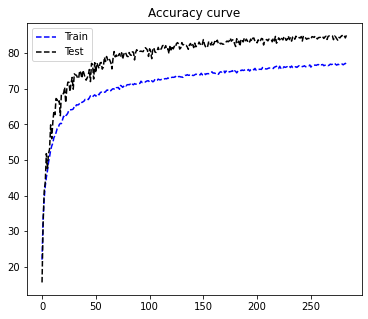

In [20]:
fig, ax1 = plt.subplots(1, 1, figsize=(6,5))
style = '--'

ax1.plot(train_acc, style, c='blue', label='Train')
ax1.plot(test_acc, style, c='black', label='Test')

ax1.title.set_text('Accuracy curve')

ax1.legend()

plt.savefig('./plots/metrics.png')

# 87% Accuracy Goal

We continue training once we have achieved our 85% accuracy goal.



In [23]:
EPOCHS = 5000
scheduler = optim.lr_scheduler.OneCycleLR(optimizer, max_lr=0.05, epochs=EPOCHS, steps_per_epoch=len(train_loader))

for epoch in range(EPOCHS):
  
  print("EPOCH:", epoch)
  train(model, device, train_loader, optimizer, epoch)
  test(model, device, test_loader)
  scheduler.step()

  if test_acc[-1] >= 87.0: 
    break 

torch.save(model.state_dict(), './saved_models/model_weights_87.pth')

EPOCH: 0


  0%|          | 0/196 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
Loss=0.6624776124954224 Batch_id=195 Accuracy=77.38: 100%|██████████| 196/196 [00:08<00:00, 21.96it/s]



Test set: Average loss: 0.0018, Accuracy: 8442/10000 (84.42%)

EPOCH: 1


Loss=0.5322467088699341 Batch_id=195 Accuracy=77.33: 100%|██████████| 196/196 [00:08<00:00, 22.05it/s]



Test set: Average loss: 0.0017, Accuracy: 8515/10000 (85.15%)

EPOCH: 2


Loss=0.6791876554489136 Batch_id=195 Accuracy=77.44: 100%|██████████| 196/196 [00:08<00:00, 22.03it/s]



Test set: Average loss: 0.0019, Accuracy: 8420/10000 (84.20%)

EPOCH: 3


Loss=0.5695219039916992 Batch_id=195 Accuracy=76.91: 100%|██████████| 196/196 [00:08<00:00, 22.11it/s]



Test set: Average loss: 0.0018, Accuracy: 8464/10000 (84.64%)

EPOCH: 4


Loss=0.533117413520813 Batch_id=195 Accuracy=77.13: 100%|██████████| 196/196 [00:08<00:00, 21.86it/s]



Test set: Average loss: 0.0018, Accuracy: 8481/10000 (84.81%)

EPOCH: 5


Loss=0.7097572088241577 Batch_id=195 Accuracy=77.33: 100%|██████████| 196/196 [00:08<00:00, 22.04it/s]



Test set: Average loss: 0.0017, Accuracy: 8503/10000 (85.03%)

EPOCH: 6


Loss=0.50787353515625 Batch_id=195 Accuracy=77.52: 100%|██████████| 196/196 [00:09<00:00, 21.64it/s]



Test set: Average loss: 0.0017, Accuracy: 8543/10000 (85.43%)

EPOCH: 7


Loss=0.9356430768966675 Batch_id=195 Accuracy=77.43: 100%|██████████| 196/196 [00:09<00:00, 21.74it/s]



Test set: Average loss: 0.0017, Accuracy: 8539/10000 (85.39%)

EPOCH: 8


Loss=0.6072443127632141 Batch_id=195 Accuracy=77.17: 100%|██████████| 196/196 [00:08<00:00, 22.00it/s]



Test set: Average loss: 0.0019, Accuracy: 8450/10000 (84.50%)

EPOCH: 9


Loss=0.7245720028877258 Batch_id=195 Accuracy=77.36: 100%|██████████| 196/196 [00:08<00:00, 22.02it/s]



Test set: Average loss: 0.0017, Accuracy: 8510/10000 (85.10%)

EPOCH: 10


Loss=0.6383559107780457 Batch_id=195 Accuracy=77.21: 100%|██████████| 196/196 [00:08<00:00, 22.04it/s]



Test set: Average loss: 0.0018, Accuracy: 8480/10000 (84.80%)

EPOCH: 11


Loss=0.7140477895736694 Batch_id=195 Accuracy=77.45: 100%|██████████| 196/196 [00:08<00:00, 21.84it/s]



Test set: Average loss: 0.0018, Accuracy: 8476/10000 (84.76%)

EPOCH: 12


Loss=0.6607999801635742 Batch_id=195 Accuracy=77.31: 100%|██████████| 196/196 [00:08<00:00, 21.78it/s]



Test set: Average loss: 0.0017, Accuracy: 8560/10000 (85.60%)

EPOCH: 13


Loss=0.7529925107955933 Batch_id=195 Accuracy=77.45: 100%|██████████| 196/196 [00:08<00:00, 22.03it/s]



Test set: Average loss: 0.0017, Accuracy: 8572/10000 (85.72%)

EPOCH: 14


Loss=0.5905402302742004 Batch_id=195 Accuracy=77.40: 100%|██████████| 196/196 [00:09<00:00, 21.71it/s]



Test set: Average loss: 0.0017, Accuracy: 8523/10000 (85.23%)

EPOCH: 15


Loss=0.6259607076644897 Batch_id=195 Accuracy=77.48: 100%|██████████| 196/196 [00:08<00:00, 21.88it/s]



Test set: Average loss: 0.0018, Accuracy: 8545/10000 (85.45%)

EPOCH: 16


Loss=0.4990391135215759 Batch_id=195 Accuracy=77.13: 100%|██████████| 196/196 [00:09<00:00, 21.77it/s]



Test set: Average loss: 0.0018, Accuracy: 8501/10000 (85.01%)

EPOCH: 17


Loss=0.5814375877380371 Batch_id=195 Accuracy=77.23: 100%|██████████| 196/196 [00:08<00:00, 21.82it/s]



Test set: Average loss: 0.0017, Accuracy: 8543/10000 (85.43%)

EPOCH: 18


Loss=0.7182396650314331 Batch_id=195 Accuracy=77.22: 100%|██████████| 196/196 [00:08<00:00, 21.89it/s]



Test set: Average loss: 0.0018, Accuracy: 8520/10000 (85.20%)

EPOCH: 19


Loss=0.7222449779510498 Batch_id=195 Accuracy=77.38: 100%|██████████| 196/196 [00:08<00:00, 21.99it/s]



Test set: Average loss: 0.0018, Accuracy: 8499/10000 (84.99%)

EPOCH: 20


Loss=0.6234556436538696 Batch_id=195 Accuracy=77.55: 100%|██████████| 196/196 [00:08<00:00, 21.90it/s]



Test set: Average loss: 0.0017, Accuracy: 8545/10000 (85.45%)

EPOCH: 21


Loss=0.6310787200927734 Batch_id=195 Accuracy=77.84: 100%|██████████| 196/196 [00:08<00:00, 21.97it/s]



Test set: Average loss: 0.0018, Accuracy: 8493/10000 (84.93%)

EPOCH: 22


Loss=0.7310906648635864 Batch_id=195 Accuracy=77.34: 100%|██████████| 196/196 [00:08<00:00, 22.03it/s]



Test set: Average loss: 0.0017, Accuracy: 8553/10000 (85.53%)

EPOCH: 23


Loss=0.8731765747070312 Batch_id=195 Accuracy=77.44: 100%|██████████| 196/196 [00:09<00:00, 21.72it/s]



Test set: Average loss: 0.0017, Accuracy: 8546/10000 (85.46%)

EPOCH: 24


Loss=0.8832730054855347 Batch_id=195 Accuracy=77.40: 100%|██████████| 196/196 [00:09<00:00, 21.76it/s]



Test set: Average loss: 0.0017, Accuracy: 8488/10000 (84.88%)

EPOCH: 25


Loss=0.6040526628494263 Batch_id=195 Accuracy=77.42: 100%|██████████| 196/196 [00:08<00:00, 21.96it/s]



Test set: Average loss: 0.0017, Accuracy: 8532/10000 (85.32%)

EPOCH: 26


Loss=0.7050930261611938 Batch_id=195 Accuracy=77.14: 100%|██████████| 196/196 [00:08<00:00, 21.85it/s]



Test set: Average loss: 0.0017, Accuracy: 8542/10000 (85.42%)

EPOCH: 27


Loss=0.5691615343093872 Batch_id=195 Accuracy=77.36: 100%|██████████| 196/196 [00:08<00:00, 21.87it/s]



Test set: Average loss: 0.0017, Accuracy: 8497/10000 (84.97%)

EPOCH: 28


Loss=0.7030657529830933 Batch_id=195 Accuracy=77.64: 100%|██████████| 196/196 [00:08<00:00, 21.92it/s]



Test set: Average loss: 0.0017, Accuracy: 8520/10000 (85.20%)

EPOCH: 29


Loss=0.5900260210037231 Batch_id=195 Accuracy=77.65: 100%|██████████| 196/196 [00:08<00:00, 21.93it/s]



Test set: Average loss: 0.0019, Accuracy: 8462/10000 (84.62%)

EPOCH: 30


Loss=0.6024961471557617 Batch_id=195 Accuracy=77.53: 100%|██████████| 196/196 [00:09<00:00, 21.56it/s]



Test set: Average loss: 0.0018, Accuracy: 8503/10000 (85.03%)

EPOCH: 31


Loss=0.9411527514457703 Batch_id=195 Accuracy=77.44: 100%|██████████| 196/196 [00:08<00:00, 21.94it/s]



Test set: Average loss: 0.0017, Accuracy: 8540/10000 (85.40%)

EPOCH: 32


Loss=0.8670355677604675 Batch_id=195 Accuracy=77.75: 100%|██████████| 196/196 [00:08<00:00, 22.05it/s]



Test set: Average loss: 0.0018, Accuracy: 8496/10000 (84.96%)

EPOCH: 33


Loss=0.8460723757743835 Batch_id=195 Accuracy=77.72: 100%|██████████| 196/196 [00:08<00:00, 22.01it/s]



Test set: Average loss: 0.0017, Accuracy: 8498/10000 (84.98%)

EPOCH: 34


Loss=0.6555927991867065 Batch_id=195 Accuracy=77.45: 100%|██████████| 196/196 [00:09<00:00, 21.76it/s]



Test set: Average loss: 0.0018, Accuracy: 8500/10000 (85.00%)

EPOCH: 35


Loss=0.6734161376953125 Batch_id=195 Accuracy=77.22: 100%|██████████| 196/196 [00:08<00:00, 21.98it/s]



Test set: Average loss: 0.0017, Accuracy: 8514/10000 (85.14%)

EPOCH: 36


Loss=0.46206411719322205 Batch_id=195 Accuracy=77.65: 100%|██████████| 196/196 [00:08<00:00, 21.86it/s]



Test set: Average loss: 0.0016, Accuracy: 8559/10000 (85.59%)

EPOCH: 37


Loss=0.6124903559684753 Batch_id=195 Accuracy=77.79: 100%|██████████| 196/196 [00:08<00:00, 21.84it/s]



Test set: Average loss: 0.0017, Accuracy: 8546/10000 (85.46%)

EPOCH: 38


Loss=0.6508477330207825 Batch_id=195 Accuracy=77.86: 100%|██████████| 196/196 [00:09<00:00, 21.71it/s]



Test set: Average loss: 0.0018, Accuracy: 8443/10000 (84.43%)

EPOCH: 39


Loss=0.4123775064945221 Batch_id=195 Accuracy=77.91: 100%|██████████| 196/196 [00:09<00:00, 21.74it/s]



Test set: Average loss: 0.0017, Accuracy: 8589/10000 (85.89%)

EPOCH: 40


Loss=0.6441879272460938 Batch_id=195 Accuracy=77.65: 100%|██████████| 196/196 [00:09<00:00, 21.50it/s]



Test set: Average loss: 0.0018, Accuracy: 8482/10000 (84.82%)

EPOCH: 41


Loss=0.7975724935531616 Batch_id=195 Accuracy=77.95: 100%|██████████| 196/196 [00:09<00:00, 21.72it/s]



Test set: Average loss: 0.0017, Accuracy: 8572/10000 (85.72%)

EPOCH: 42


Loss=0.6964904069900513 Batch_id=195 Accuracy=77.73: 100%|██████████| 196/196 [00:09<00:00, 21.74it/s]



Test set: Average loss: 0.0017, Accuracy: 8590/10000 (85.90%)

EPOCH: 43


Loss=0.533507764339447 Batch_id=195 Accuracy=77.82: 100%|██████████| 196/196 [00:09<00:00, 21.71it/s]



Test set: Average loss: 0.0017, Accuracy: 8485/10000 (84.85%)

EPOCH: 44


Loss=0.6660481691360474 Batch_id=195 Accuracy=77.54: 100%|██████████| 196/196 [00:09<00:00, 21.59it/s]



Test set: Average loss: 0.0017, Accuracy: 8578/10000 (85.78%)

EPOCH: 45


Loss=0.421933650970459 Batch_id=195 Accuracy=77.68: 100%|██████████| 196/196 [00:08<00:00, 21.79it/s]



Test set: Average loss: 0.0017, Accuracy: 8537/10000 (85.37%)

EPOCH: 46


Loss=0.6023705005645752 Batch_id=195 Accuracy=77.84: 100%|██████████| 196/196 [00:09<00:00, 21.55it/s]



Test set: Average loss: 0.0017, Accuracy: 8516/10000 (85.16%)

EPOCH: 47


Loss=0.6705905199050903 Batch_id=195 Accuracy=77.65: 100%|██████████| 196/196 [00:09<00:00, 21.73it/s]



Test set: Average loss: 0.0017, Accuracy: 8496/10000 (84.96%)

EPOCH: 48


Loss=0.700071394443512 Batch_id=195 Accuracy=77.69: 100%|██████████| 196/196 [00:09<00:00, 21.29it/s]



Test set: Average loss: 0.0018, Accuracy: 8501/10000 (85.01%)

EPOCH: 49


Loss=0.5658029913902283 Batch_id=195 Accuracy=77.65: 100%|██████████| 196/196 [00:08<00:00, 21.82it/s]



Test set: Average loss: 0.0017, Accuracy: 8527/10000 (85.27%)

EPOCH: 50


Loss=0.7672417163848877 Batch_id=195 Accuracy=77.93: 100%|██████████| 196/196 [00:09<00:00, 21.55it/s]



Test set: Average loss: 0.0017, Accuracy: 8549/10000 (85.49%)

EPOCH: 51


Loss=0.5611675977706909 Batch_id=195 Accuracy=77.60: 100%|██████████| 196/196 [00:09<00:00, 21.56it/s]



Test set: Average loss: 0.0017, Accuracy: 8552/10000 (85.52%)

EPOCH: 52


Loss=0.6845266222953796 Batch_id=195 Accuracy=77.57: 100%|██████████| 196/196 [00:08<00:00, 21.83it/s]



Test set: Average loss: 0.0017, Accuracy: 8532/10000 (85.32%)

EPOCH: 53


Loss=0.8479254841804504 Batch_id=195 Accuracy=77.67: 100%|██████████| 196/196 [00:09<00:00, 21.70it/s]



Test set: Average loss: 0.0017, Accuracy: 8535/10000 (85.35%)

EPOCH: 54


Loss=0.7323898077011108 Batch_id=195 Accuracy=77.83: 100%|██████████| 196/196 [00:09<00:00, 21.44it/s]



Test set: Average loss: 0.0017, Accuracy: 8528/10000 (85.28%)

EPOCH: 55


Loss=0.6351581811904907 Batch_id=195 Accuracy=78.24: 100%|██████████| 196/196 [00:09<00:00, 21.44it/s]



Test set: Average loss: 0.0018, Accuracy: 8502/10000 (85.02%)

EPOCH: 56


Loss=0.8277261853218079 Batch_id=195 Accuracy=78.08: 100%|██████████| 196/196 [00:09<00:00, 21.59it/s]



Test set: Average loss: 0.0016, Accuracy: 8590/10000 (85.90%)

EPOCH: 57


Loss=0.5472763776779175 Batch_id=195 Accuracy=77.92: 100%|██████████| 196/196 [00:09<00:00, 21.53it/s]



Test set: Average loss: 0.0017, Accuracy: 8513/10000 (85.13%)

EPOCH: 58


Loss=0.9813966751098633 Batch_id=195 Accuracy=77.95: 100%|██████████| 196/196 [00:09<00:00, 21.58it/s]



Test set: Average loss: 0.0017, Accuracy: 8573/10000 (85.73%)

EPOCH: 59


Loss=0.5724565982818604 Batch_id=195 Accuracy=77.86: 100%|██████████| 196/196 [00:09<00:00, 21.67it/s]



Test set: Average loss: 0.0017, Accuracy: 8539/10000 (85.39%)

EPOCH: 60


Loss=0.9202300310134888 Batch_id=195 Accuracy=77.95: 100%|██████████| 196/196 [00:09<00:00, 21.09it/s]



Test set: Average loss: 0.0017, Accuracy: 8493/10000 (84.93%)

EPOCH: 61


Loss=0.8172637224197388 Batch_id=195 Accuracy=77.88: 100%|██████████| 196/196 [00:09<00:00, 21.75it/s]



Test set: Average loss: 0.0017, Accuracy: 8576/10000 (85.76%)

EPOCH: 62


Loss=0.5190941095352173 Batch_id=195 Accuracy=77.80: 100%|██████████| 196/196 [00:09<00:00, 21.62it/s]



Test set: Average loss: 0.0017, Accuracy: 8499/10000 (84.99%)

EPOCH: 63


Loss=0.8415031433105469 Batch_id=195 Accuracy=77.94: 100%|██████████| 196/196 [00:09<00:00, 21.62it/s]



Test set: Average loss: 0.0017, Accuracy: 8557/10000 (85.57%)

EPOCH: 64


Loss=0.6706821322441101 Batch_id=195 Accuracy=78.13: 100%|██████████| 196/196 [00:09<00:00, 21.40it/s]



Test set: Average loss: 0.0017, Accuracy: 8556/10000 (85.56%)

EPOCH: 65


Loss=0.8467000722885132 Batch_id=195 Accuracy=77.96: 100%|██████████| 196/196 [00:08<00:00, 21.92it/s]



Test set: Average loss: 0.0016, Accuracy: 8562/10000 (85.62%)

EPOCH: 66


Loss=0.6569481492042542 Batch_id=195 Accuracy=77.78: 100%|██████████| 196/196 [00:08<00:00, 21.78it/s]



Test set: Average loss: 0.0018, Accuracy: 8477/10000 (84.77%)

EPOCH: 67


Loss=0.6029732823371887 Batch_id=195 Accuracy=78.14: 100%|██████████| 196/196 [00:09<00:00, 21.47it/s]



Test set: Average loss: 0.0017, Accuracy: 8541/10000 (85.41%)

EPOCH: 68


Loss=0.5010693073272705 Batch_id=195 Accuracy=78.34: 100%|██████████| 196/196 [00:09<00:00, 21.51it/s]



Test set: Average loss: 0.0017, Accuracy: 8495/10000 (84.95%)

EPOCH: 69


Loss=0.7263979911804199 Batch_id=195 Accuracy=77.92: 100%|██████████| 196/196 [00:09<00:00, 21.73it/s]



Test set: Average loss: 0.0017, Accuracy: 8499/10000 (84.99%)

EPOCH: 70


Loss=0.7705233693122864 Batch_id=195 Accuracy=77.91: 100%|██████████| 196/196 [00:09<00:00, 21.44it/s]



Test set: Average loss: 0.0016, Accuracy: 8569/10000 (85.69%)

EPOCH: 71


Loss=0.6303370594978333 Batch_id=195 Accuracy=78.02: 100%|██████████| 196/196 [00:09<00:00, 21.63it/s]



Test set: Average loss: 0.0017, Accuracy: 8589/10000 (85.89%)

EPOCH: 72


Loss=0.7687624096870422 Batch_id=195 Accuracy=77.78: 100%|██████████| 196/196 [00:09<00:00, 21.39it/s]



Test set: Average loss: 0.0017, Accuracy: 8504/10000 (85.04%)

EPOCH: 73


Loss=0.6299440860748291 Batch_id=195 Accuracy=78.02: 100%|██████████| 196/196 [00:09<00:00, 21.26it/s]



Test set: Average loss: 0.0017, Accuracy: 8562/10000 (85.62%)

EPOCH: 74


Loss=0.6971389055252075 Batch_id=195 Accuracy=77.89: 100%|██████████| 196/196 [00:09<00:00, 21.49it/s]



Test set: Average loss: 0.0017, Accuracy: 8540/10000 (85.40%)

EPOCH: 75


Loss=0.8146891593933105 Batch_id=195 Accuracy=77.85: 100%|██████████| 196/196 [00:09<00:00, 21.36it/s]



Test set: Average loss: 0.0017, Accuracy: 8546/10000 (85.46%)

EPOCH: 76


Loss=0.6767515540122986 Batch_id=195 Accuracy=78.04: 100%|██████████| 196/196 [00:09<00:00, 21.52it/s]



Test set: Average loss: 0.0017, Accuracy: 8490/10000 (84.90%)

EPOCH: 77


Loss=0.78962242603302 Batch_id=195 Accuracy=78.07: 100%|██████████| 196/196 [00:09<00:00, 21.56it/s]



Test set: Average loss: 0.0016, Accuracy: 8557/10000 (85.57%)

EPOCH: 78


Loss=0.607318639755249 Batch_id=195 Accuracy=78.07: 100%|██████████| 196/196 [00:09<00:00, 21.46it/s]



Test set: Average loss: 0.0017, Accuracy: 8566/10000 (85.66%)

EPOCH: 79


Loss=0.5654663443565369 Batch_id=195 Accuracy=77.88: 100%|██████████| 196/196 [00:09<00:00, 21.71it/s]



Test set: Average loss: 0.0017, Accuracy: 8543/10000 (85.43%)

EPOCH: 80


Loss=0.6027618646621704 Batch_id=195 Accuracy=78.02: 100%|██████████| 196/196 [00:09<00:00, 21.20it/s]



Test set: Average loss: 0.0018, Accuracy: 8413/10000 (84.13%)

EPOCH: 81


Loss=0.6980254650115967 Batch_id=195 Accuracy=78.45: 100%|██████████| 196/196 [00:09<00:00, 21.47it/s]



Test set: Average loss: 0.0016, Accuracy: 8592/10000 (85.92%)

EPOCH: 82


Loss=0.6519609689712524 Batch_id=195 Accuracy=78.31: 100%|██████████| 196/196 [00:09<00:00, 21.57it/s]



Test set: Average loss: 0.0017, Accuracy: 8560/10000 (85.60%)

EPOCH: 83


Loss=0.567171037197113 Batch_id=195 Accuracy=78.04: 100%|██████████| 196/196 [00:09<00:00, 21.33it/s]



Test set: Average loss: 0.0017, Accuracy: 8556/10000 (85.56%)

EPOCH: 84


Loss=0.8495434522628784 Batch_id=195 Accuracy=78.12: 100%|██████████| 196/196 [00:09<00:00, 21.22it/s]



Test set: Average loss: 0.0017, Accuracy: 8573/10000 (85.73%)

EPOCH: 85


Loss=0.6633847951889038 Batch_id=195 Accuracy=78.17: 100%|██████████| 196/196 [00:09<00:00, 21.49it/s]



Test set: Average loss: 0.0017, Accuracy: 8567/10000 (85.67%)

EPOCH: 86


Loss=0.7154890298843384 Batch_id=195 Accuracy=77.96: 100%|██████████| 196/196 [00:09<00:00, 21.22it/s]



Test set: Average loss: 0.0017, Accuracy: 8556/10000 (85.56%)

EPOCH: 87


Loss=0.783766508102417 Batch_id=195 Accuracy=78.10: 100%|██████████| 196/196 [00:09<00:00, 21.51it/s]



Test set: Average loss: 0.0017, Accuracy: 8570/10000 (85.70%)

EPOCH: 88


Loss=0.8082985877990723 Batch_id=195 Accuracy=77.93: 100%|██████████| 196/196 [00:09<00:00, 21.35it/s]



Test set: Average loss: 0.0016, Accuracy: 8582/10000 (85.82%)

EPOCH: 89


Loss=0.6414822340011597 Batch_id=195 Accuracy=78.19: 100%|██████████| 196/196 [00:09<00:00, 21.26it/s]



Test set: Average loss: 0.0017, Accuracy: 8567/10000 (85.67%)

EPOCH: 90


Loss=0.4942229688167572 Batch_id=195 Accuracy=78.12: 100%|██████████| 196/196 [00:09<00:00, 21.51it/s]



Test set: Average loss: 0.0017, Accuracy: 8570/10000 (85.70%)

EPOCH: 91


Loss=0.5271164178848267 Batch_id=195 Accuracy=78.06: 100%|██████████| 196/196 [00:09<00:00, 21.60it/s]



Test set: Average loss: 0.0017, Accuracy: 8588/10000 (85.88%)

EPOCH: 92


Loss=0.5767950415611267 Batch_id=195 Accuracy=78.14: 100%|██████████| 196/196 [00:09<00:00, 21.61it/s]



Test set: Average loss: 0.0017, Accuracy: 8537/10000 (85.37%)

EPOCH: 93


Loss=0.7746832370758057 Batch_id=195 Accuracy=78.10: 100%|██████████| 196/196 [00:09<00:00, 21.26it/s]



Test set: Average loss: 0.0017, Accuracy: 8542/10000 (85.42%)

EPOCH: 94


Loss=0.6910609006881714 Batch_id=195 Accuracy=78.20: 100%|██████████| 196/196 [00:09<00:00, 21.30it/s]



Test set: Average loss: 0.0017, Accuracy: 8567/10000 (85.67%)

EPOCH: 95


Loss=0.6133819818496704 Batch_id=195 Accuracy=78.37: 100%|██████████| 196/196 [00:09<00:00, 21.42it/s]



Test set: Average loss: 0.0016, Accuracy: 8590/10000 (85.90%)

EPOCH: 96


Loss=0.6932358741760254 Batch_id=195 Accuracy=77.98: 100%|██████████| 196/196 [00:09<00:00, 21.20it/s]



Test set: Average loss: 0.0017, Accuracy: 8589/10000 (85.89%)

EPOCH: 97


Loss=0.45991840958595276 Batch_id=195 Accuracy=78.37: 100%|██████████| 196/196 [00:09<00:00, 21.45it/s]



Test set: Average loss: 0.0017, Accuracy: 8568/10000 (85.68%)

EPOCH: 98


Loss=0.5606551170349121 Batch_id=195 Accuracy=78.14: 100%|██████████| 196/196 [00:09<00:00, 21.36it/s]



Test set: Average loss: 0.0017, Accuracy: 8564/10000 (85.64%)

EPOCH: 99


Loss=0.6535269021987915 Batch_id=195 Accuracy=78.21: 100%|██████████| 196/196 [00:09<00:00, 21.14it/s]



Test set: Average loss: 0.0016, Accuracy: 8603/10000 (86.03%)

EPOCH: 100


Loss=0.7480245232582092 Batch_id=195 Accuracy=78.41: 100%|██████████| 196/196 [00:09<00:00, 21.54it/s]



Test set: Average loss: 0.0016, Accuracy: 8573/10000 (85.73%)

EPOCH: 101


Loss=0.5468030571937561 Batch_id=195 Accuracy=78.39: 100%|██████████| 196/196 [00:09<00:00, 21.26it/s]



Test set: Average loss: 0.0016, Accuracy: 8598/10000 (85.98%)

EPOCH: 102


Loss=0.7014913558959961 Batch_id=195 Accuracy=78.10: 100%|██████████| 196/196 [00:09<00:00, 21.04it/s]



Test set: Average loss: 0.0016, Accuracy: 8614/10000 (86.14%)

EPOCH: 103


Loss=0.7852819561958313 Batch_id=195 Accuracy=78.32: 100%|██████████| 196/196 [00:09<00:00, 21.54it/s]



Test set: Average loss: 0.0017, Accuracy: 8560/10000 (85.60%)

EPOCH: 104


Loss=0.44026118516921997 Batch_id=195 Accuracy=78.45: 100%|██████████| 196/196 [00:09<00:00, 21.37it/s]



Test set: Average loss: 0.0016, Accuracy: 8578/10000 (85.78%)

EPOCH: 105


Loss=0.8493778109550476 Batch_id=195 Accuracy=78.10: 100%|██████████| 196/196 [00:09<00:00, 21.61it/s]



Test set: Average loss: 0.0017, Accuracy: 8589/10000 (85.89%)

EPOCH: 106


Loss=0.5505111217498779 Batch_id=195 Accuracy=78.20: 100%|██████████| 196/196 [00:09<00:00, 21.51it/s]



Test set: Average loss: 0.0016, Accuracy: 8583/10000 (85.83%)

EPOCH: 107


Loss=0.6506094932556152 Batch_id=195 Accuracy=78.46: 100%|██████████| 196/196 [00:09<00:00, 21.24it/s]



Test set: Average loss: 0.0016, Accuracy: 8603/10000 (86.03%)

EPOCH: 108


Loss=0.69718337059021 Batch_id=195 Accuracy=78.27: 100%|██████████| 196/196 [00:09<00:00, 21.34it/s]



Test set: Average loss: 0.0018, Accuracy: 8487/10000 (84.87%)

EPOCH: 109


Loss=0.5202652215957642 Batch_id=195 Accuracy=78.26: 100%|██████████| 196/196 [00:09<00:00, 21.13it/s]



Test set: Average loss: 0.0016, Accuracy: 8576/10000 (85.76%)

EPOCH: 110


Loss=0.8022810816764832 Batch_id=195 Accuracy=78.27: 100%|██████████| 196/196 [00:09<00:00, 21.28it/s]



Test set: Average loss: 0.0017, Accuracy: 8575/10000 (85.75%)

EPOCH: 111


Loss=0.37275978922843933 Batch_id=195 Accuracy=78.29: 100%|██████████| 196/196 [00:09<00:00, 21.25it/s]



Test set: Average loss: 0.0017, Accuracy: 8604/10000 (86.04%)

EPOCH: 112


Loss=0.7607250213623047 Batch_id=195 Accuracy=78.25: 100%|██████████| 196/196 [00:09<00:00, 21.20it/s]



Test set: Average loss: 0.0017, Accuracy: 8587/10000 (85.87%)

EPOCH: 113


Loss=0.5780304670333862 Batch_id=195 Accuracy=78.05: 100%|██████████| 196/196 [00:09<00:00, 21.36it/s]



Test set: Average loss: 0.0017, Accuracy: 8598/10000 (85.98%)

EPOCH: 114


Loss=0.5102649927139282 Batch_id=195 Accuracy=78.32: 100%|██████████| 196/196 [00:09<00:00, 21.38it/s]



Test set: Average loss: 0.0016, Accuracy: 8595/10000 (85.95%)

EPOCH: 115


Loss=0.573386013507843 Batch_id=195 Accuracy=78.62: 100%|██████████| 196/196 [00:09<00:00, 21.03it/s]



Test set: Average loss: 0.0017, Accuracy: 8562/10000 (85.62%)

EPOCH: 116


Loss=0.6748043298721313 Batch_id=195 Accuracy=78.35: 100%|██████████| 196/196 [00:09<00:00, 21.44it/s]



Test set: Average loss: 0.0017, Accuracy: 8587/10000 (85.87%)

EPOCH: 117


Loss=0.6779030561447144 Batch_id=195 Accuracy=78.49: 100%|██████████| 196/196 [00:09<00:00, 21.49it/s]



Test set: Average loss: 0.0016, Accuracy: 8589/10000 (85.89%)

EPOCH: 118


Loss=0.536765456199646 Batch_id=195 Accuracy=78.26: 100%|██████████| 196/196 [00:09<00:00, 21.19it/s]



Test set: Average loss: 0.0016, Accuracy: 8563/10000 (85.63%)

EPOCH: 119


Loss=0.5657378435134888 Batch_id=195 Accuracy=78.35: 100%|██████████| 196/196 [00:09<00:00, 21.17it/s]



Test set: Average loss: 0.0017, Accuracy: 8575/10000 (85.75%)

EPOCH: 120


Loss=0.757777988910675 Batch_id=195 Accuracy=78.54: 100%|██████████| 196/196 [00:09<00:00, 21.17it/s]



Test set: Average loss: 0.0017, Accuracy: 8583/10000 (85.83%)

EPOCH: 121


Loss=0.5360702276229858 Batch_id=195 Accuracy=78.54: 100%|██████████| 196/196 [00:09<00:00, 21.27it/s]



Test set: Average loss: 0.0017, Accuracy: 8557/10000 (85.57%)

EPOCH: 122


Loss=0.6549757719039917 Batch_id=195 Accuracy=78.29: 100%|██████████| 196/196 [00:09<00:00, 21.04it/s]



Test set: Average loss: 0.0017, Accuracy: 8597/10000 (85.97%)

EPOCH: 123


Loss=0.5676330327987671 Batch_id=195 Accuracy=78.52: 100%|██████████| 196/196 [00:09<00:00, 21.29it/s]



Test set: Average loss: 0.0017, Accuracy: 8585/10000 (85.85%)

EPOCH: 124


Loss=0.6430888772010803 Batch_id=195 Accuracy=78.15: 100%|██████████| 196/196 [00:09<00:00, 21.20it/s]



Test set: Average loss: 0.0016, Accuracy: 8621/10000 (86.21%)

EPOCH: 125


Loss=0.4538932740688324 Batch_id=195 Accuracy=78.68: 100%|██████████| 196/196 [00:09<00:00, 21.08it/s]



Test set: Average loss: 0.0017, Accuracy: 8530/10000 (85.30%)

EPOCH: 126


Loss=0.6511216163635254 Batch_id=195 Accuracy=78.36: 100%|██████████| 196/196 [00:09<00:00, 21.23it/s]



Test set: Average loss: 0.0016, Accuracy: 8590/10000 (85.90%)

EPOCH: 127


Loss=0.5703140497207642 Batch_id=195 Accuracy=78.53: 100%|██████████| 196/196 [00:09<00:00, 21.20it/s]



Test set: Average loss: 0.0017, Accuracy: 8562/10000 (85.62%)

EPOCH: 128


Loss=0.5837134122848511 Batch_id=195 Accuracy=78.58: 100%|██████████| 196/196 [00:09<00:00, 20.83it/s]



Test set: Average loss: 0.0016, Accuracy: 8628/10000 (86.28%)

EPOCH: 129


Loss=0.6684297919273376 Batch_id=195 Accuracy=78.59: 100%|██████████| 196/196 [00:09<00:00, 21.26it/s]



Test set: Average loss: 0.0016, Accuracy: 8621/10000 (86.21%)

EPOCH: 130


Loss=0.559678852558136 Batch_id=195 Accuracy=78.74: 100%|██████████| 196/196 [00:09<00:00, 21.23it/s]



Test set: Average loss: 0.0016, Accuracy: 8602/10000 (86.02%)

EPOCH: 131


Loss=0.6848688125610352 Batch_id=195 Accuracy=78.65: 100%|██████████| 196/196 [00:09<00:00, 21.05it/s]



Test set: Average loss: 0.0016, Accuracy: 8601/10000 (86.01%)

EPOCH: 132


Loss=0.5388222932815552 Batch_id=195 Accuracy=78.63: 100%|██████████| 196/196 [00:09<00:00, 21.44it/s]



Test set: Average loss: 0.0016, Accuracy: 8622/10000 (86.22%)

EPOCH: 133


Loss=0.7649907469749451 Batch_id=195 Accuracy=78.74: 100%|██████████| 196/196 [00:09<00:00, 21.27it/s]



Test set: Average loss: 0.0016, Accuracy: 8586/10000 (85.86%)

EPOCH: 134


Loss=0.5618212819099426 Batch_id=195 Accuracy=78.42: 100%|██████████| 196/196 [00:09<00:00, 21.01it/s]



Test set: Average loss: 0.0016, Accuracy: 8585/10000 (85.85%)

EPOCH: 135


Loss=0.8653672933578491 Batch_id=195 Accuracy=78.50: 100%|██████████| 196/196 [00:09<00:00, 20.83it/s]



Test set: Average loss: 0.0016, Accuracy: 8644/10000 (86.44%)

EPOCH: 136


Loss=0.6994999051094055 Batch_id=195 Accuracy=78.35: 100%|██████████| 196/196 [00:09<00:00, 21.04it/s]



Test set: Average loss: 0.0017, Accuracy: 8561/10000 (85.61%)

EPOCH: 137


Loss=0.5840525031089783 Batch_id=195 Accuracy=78.61: 100%|██████████| 196/196 [00:09<00:00, 20.95it/s]



Test set: Average loss: 0.0016, Accuracy: 8600/10000 (86.00%)

EPOCH: 138


Loss=0.6229135990142822 Batch_id=195 Accuracy=78.78: 100%|██████████| 196/196 [00:09<00:00, 20.99it/s]



Test set: Average loss: 0.0016, Accuracy: 8655/10000 (86.55%)

EPOCH: 139


Loss=0.771725058555603 Batch_id=195 Accuracy=78.77: 100%|██████████| 196/196 [00:09<00:00, 21.34it/s]



Test set: Average loss: 0.0017, Accuracy: 8583/10000 (85.83%)

EPOCH: 140


Loss=0.6060681939125061 Batch_id=195 Accuracy=78.97: 100%|██████████| 196/196 [00:09<00:00, 21.28it/s]



Test set: Average loss: 0.0017, Accuracy: 8577/10000 (85.77%)

EPOCH: 141


Loss=0.5764964818954468 Batch_id=195 Accuracy=78.39: 100%|██████████| 196/196 [00:09<00:00, 21.06it/s]



Test set: Average loss: 0.0015, Accuracy: 8648/10000 (86.48%)

EPOCH: 142


Loss=0.5231837034225464 Batch_id=195 Accuracy=78.55: 100%|██████████| 196/196 [00:09<00:00, 21.01it/s]



Test set: Average loss: 0.0016, Accuracy: 8596/10000 (85.96%)

EPOCH: 143


Loss=0.9216141700744629 Batch_id=195 Accuracy=78.68: 100%|██████████| 196/196 [00:09<00:00, 21.07it/s]



Test set: Average loss: 0.0016, Accuracy: 8593/10000 (85.93%)

EPOCH: 144


Loss=0.8802996873855591 Batch_id=195 Accuracy=78.78: 100%|██████████| 196/196 [00:09<00:00, 21.07it/s]



Test set: Average loss: 0.0016, Accuracy: 8545/10000 (85.45%)

EPOCH: 145


Loss=0.4572370946407318 Batch_id=195 Accuracy=78.56: 100%|██████████| 196/196 [00:09<00:00, 21.33it/s]



Test set: Average loss: 0.0016, Accuracy: 8588/10000 (85.88%)

EPOCH: 146


Loss=0.5782222747802734 Batch_id=195 Accuracy=78.62: 100%|██████████| 196/196 [00:09<00:00, 21.41it/s]



Test set: Average loss: 0.0017, Accuracy: 8532/10000 (85.32%)

EPOCH: 147


Loss=0.7601648569107056 Batch_id=195 Accuracy=78.63: 100%|██████████| 196/196 [00:09<00:00, 20.89it/s]



Test set: Average loss: 0.0016, Accuracy: 8627/10000 (86.27%)

EPOCH: 148


Loss=0.6569015979766846 Batch_id=195 Accuracy=78.59: 100%|██████████| 196/196 [00:09<00:00, 21.17it/s]



Test set: Average loss: 0.0016, Accuracy: 8575/10000 (85.75%)

EPOCH: 149


Loss=0.47135695815086365 Batch_id=195 Accuracy=78.81: 100%|██████████| 196/196 [00:09<00:00, 21.04it/s]



Test set: Average loss: 0.0016, Accuracy: 8599/10000 (85.99%)

EPOCH: 150


Loss=0.6848580837249756 Batch_id=195 Accuracy=78.51: 100%|██████████| 196/196 [00:09<00:00, 21.21it/s]



Test set: Average loss: 0.0017, Accuracy: 8596/10000 (85.96%)

EPOCH: 151


Loss=0.7374550700187683 Batch_id=195 Accuracy=79.05: 100%|██████████| 196/196 [00:09<00:00, 21.06it/s]



Test set: Average loss: 0.0017, Accuracy: 8548/10000 (85.48%)

EPOCH: 152


Loss=0.6247568130493164 Batch_id=195 Accuracy=78.66: 100%|██████████| 196/196 [00:09<00:00, 21.15it/s]



Test set: Average loss: 0.0016, Accuracy: 8587/10000 (85.87%)

EPOCH: 153


Loss=0.6733377575874329 Batch_id=195 Accuracy=78.48: 100%|██████████| 196/196 [00:09<00:00, 21.03it/s]



Test set: Average loss: 0.0017, Accuracy: 8543/10000 (85.43%)

EPOCH: 154


Loss=0.6682292819023132 Batch_id=195 Accuracy=78.42: 100%|██████████| 196/196 [00:09<00:00, 20.90it/s]



Test set: Average loss: 0.0016, Accuracy: 8613/10000 (86.13%)

EPOCH: 155


Loss=0.5961021780967712 Batch_id=195 Accuracy=78.57: 100%|██████████| 196/196 [00:09<00:00, 21.09it/s]



Test set: Average loss: 0.0016, Accuracy: 8594/10000 (85.94%)

EPOCH: 156


Loss=0.5114467144012451 Batch_id=195 Accuracy=78.91: 100%|██████████| 196/196 [00:09<00:00, 21.45it/s]



Test set: Average loss: 0.0016, Accuracy: 8621/10000 (86.21%)

EPOCH: 157


Loss=0.6806924939155579 Batch_id=195 Accuracy=78.33: 100%|██████████| 196/196 [00:09<00:00, 20.87it/s]



Test set: Average loss: 0.0016, Accuracy: 8616/10000 (86.16%)

EPOCH: 158


Loss=0.7154358625411987 Batch_id=195 Accuracy=78.61: 100%|██████████| 196/196 [00:09<00:00, 21.01it/s]



Test set: Average loss: 0.0017, Accuracy: 8605/10000 (86.05%)

EPOCH: 159


Loss=0.7138680219650269 Batch_id=195 Accuracy=78.99: 100%|██████████| 196/196 [00:09<00:00, 20.74it/s]



Test set: Average loss: 0.0016, Accuracy: 8615/10000 (86.15%)

EPOCH: 160


Loss=0.7283741235733032 Batch_id=195 Accuracy=79.03: 100%|██████████| 196/196 [00:09<00:00, 20.88it/s]



Test set: Average loss: 0.0016, Accuracy: 8613/10000 (86.13%)

EPOCH: 161


Loss=0.49688348174095154 Batch_id=195 Accuracy=78.76: 100%|██████████| 196/196 [00:09<00:00, 21.13it/s]



Test set: Average loss: 0.0016, Accuracy: 8636/10000 (86.36%)

EPOCH: 162


Loss=0.6385167837142944 Batch_id=195 Accuracy=78.65: 100%|██████████| 196/196 [00:09<00:00, 21.32it/s]



Test set: Average loss: 0.0016, Accuracy: 8658/10000 (86.58%)

EPOCH: 163


Loss=0.9284275770187378 Batch_id=195 Accuracy=78.48: 100%|██████████| 196/196 [00:09<00:00, 20.89it/s]



Test set: Average loss: 0.0017, Accuracy: 8594/10000 (85.94%)

EPOCH: 164


Loss=0.6536447405815125 Batch_id=195 Accuracy=78.96: 100%|██████████| 196/196 [00:09<00:00, 21.22it/s]



Test set: Average loss: 0.0016, Accuracy: 8627/10000 (86.27%)

EPOCH: 165


Loss=0.7441026568412781 Batch_id=195 Accuracy=78.93: 100%|██████████| 196/196 [00:09<00:00, 20.93it/s]



Test set: Average loss: 0.0017, Accuracy: 8577/10000 (85.77%)

EPOCH: 166


Loss=0.5497058629989624 Batch_id=195 Accuracy=78.51: 100%|██████████| 196/196 [00:09<00:00, 20.67it/s]



Test set: Average loss: 0.0016, Accuracy: 8631/10000 (86.31%)

EPOCH: 167


Loss=0.6552520394325256 Batch_id=195 Accuracy=78.81: 100%|██████████| 196/196 [00:09<00:00, 20.96it/s]



Test set: Average loss: 0.0016, Accuracy: 8656/10000 (86.56%)

EPOCH: 168


Loss=0.6168789267539978 Batch_id=195 Accuracy=78.74: 100%|██████████| 196/196 [00:09<00:00, 21.02it/s]



Test set: Average loss: 0.0016, Accuracy: 8617/10000 (86.17%)

EPOCH: 169


Loss=0.4057968258857727 Batch_id=195 Accuracy=78.61: 100%|██████████| 196/196 [00:09<00:00, 20.90it/s]



Test set: Average loss: 0.0016, Accuracy: 8638/10000 (86.38%)

EPOCH: 170


Loss=0.5870260000228882 Batch_id=195 Accuracy=79.00: 100%|██████████| 196/196 [00:09<00:00, 20.94it/s]



Test set: Average loss: 0.0016, Accuracy: 8631/10000 (86.31%)

EPOCH: 171


Loss=0.6711062788963318 Batch_id=195 Accuracy=79.03: 100%|██████████| 196/196 [00:09<00:00, 20.85it/s]



Test set: Average loss: 0.0016, Accuracy: 8635/10000 (86.35%)

EPOCH: 172


Loss=0.6030279397964478 Batch_id=195 Accuracy=78.81: 100%|██████████| 196/196 [00:09<00:00, 20.96it/s]



Test set: Average loss: 0.0016, Accuracy: 8587/10000 (85.87%)

EPOCH: 173


Loss=0.5592957139015198 Batch_id=195 Accuracy=78.82: 100%|██████████| 196/196 [00:09<00:00, 20.83it/s]



Test set: Average loss: 0.0016, Accuracy: 8636/10000 (86.36%)

EPOCH: 174


Loss=0.7784837484359741 Batch_id=195 Accuracy=78.99: 100%|██████████| 196/196 [00:09<00:00, 20.67it/s]



Test set: Average loss: 0.0016, Accuracy: 8648/10000 (86.48%)

EPOCH: 175


Loss=0.6764085292816162 Batch_id=195 Accuracy=78.81: 100%|██████████| 196/196 [00:09<00:00, 20.98it/s]



Test set: Average loss: 0.0016, Accuracy: 8609/10000 (86.09%)

EPOCH: 176


Loss=0.8335155248641968 Batch_id=195 Accuracy=78.96: 100%|██████████| 196/196 [00:09<00:00, 20.88it/s]



Test set: Average loss: 0.0016, Accuracy: 8631/10000 (86.31%)

EPOCH: 177


Loss=0.6679905652999878 Batch_id=195 Accuracy=78.69: 100%|██████████| 196/196 [00:09<00:00, 20.95it/s]



Test set: Average loss: 0.0016, Accuracy: 8643/10000 (86.43%)

EPOCH: 178


Loss=0.5754285454750061 Batch_id=195 Accuracy=79.36: 100%|██████████| 196/196 [00:09<00:00, 21.26it/s]



Test set: Average loss: 0.0016, Accuracy: 8615/10000 (86.15%)

EPOCH: 179


Loss=0.5493098497390747 Batch_id=195 Accuracy=78.84: 100%|██████████| 196/196 [00:09<00:00, 20.85it/s]



Test set: Average loss: 0.0017, Accuracy: 8626/10000 (86.26%)

EPOCH: 180


Loss=0.9371881484985352 Batch_id=195 Accuracy=79.41: 100%|██████████| 196/196 [00:09<00:00, 20.79it/s]



Test set: Average loss: 0.0017, Accuracy: 8569/10000 (85.69%)

EPOCH: 181


Loss=0.5090475082397461 Batch_id=195 Accuracy=78.83: 100%|██████████| 196/196 [00:09<00:00, 20.94it/s]



Test set: Average loss: 0.0016, Accuracy: 8603/10000 (86.03%)

EPOCH: 182


Loss=0.7071951627731323 Batch_id=195 Accuracy=78.83: 100%|██████████| 196/196 [00:09<00:00, 20.58it/s]



Test set: Average loss: 0.0017, Accuracy: 8600/10000 (86.00%)

EPOCH: 183


Loss=0.36792314052581787 Batch_id=195 Accuracy=79.07: 100%|██████████| 196/196 [00:09<00:00, 20.77it/s]



Test set: Average loss: 0.0016, Accuracy: 8638/10000 (86.38%)

EPOCH: 184


Loss=0.5787967443466187 Batch_id=195 Accuracy=79.00: 100%|██████████| 196/196 [00:09<00:00, 21.01it/s]



Test set: Average loss: 0.0016, Accuracy: 8685/10000 (86.85%)

EPOCH: 185


Loss=0.7616681456565857 Batch_id=195 Accuracy=78.70: 100%|██████████| 196/196 [00:09<00:00, 20.94it/s]



Test set: Average loss: 0.0016, Accuracy: 8608/10000 (86.08%)

EPOCH: 186


Loss=0.6416334509849548 Batch_id=195 Accuracy=78.76: 100%|██████████| 196/196 [00:09<00:00, 20.77it/s]



Test set: Average loss: 0.0016, Accuracy: 8652/10000 (86.52%)

EPOCH: 187


Loss=0.6792203187942505 Batch_id=195 Accuracy=78.97: 100%|██████████| 196/196 [00:09<00:00, 20.98it/s]



Test set: Average loss: 0.0016, Accuracy: 8656/10000 (86.56%)

EPOCH: 188


Loss=0.478609174489975 Batch_id=195 Accuracy=78.82: 100%|██████████| 196/196 [00:09<00:00, 20.84it/s]



Test set: Average loss: 0.0016, Accuracy: 8661/10000 (86.61%)

EPOCH: 189


Loss=0.6593252420425415 Batch_id=195 Accuracy=79.02: 100%|██████████| 196/196 [00:09<00:00, 20.42it/s]



Test set: Average loss: 0.0016, Accuracy: 8621/10000 (86.21%)

EPOCH: 190


Loss=0.7160094380378723 Batch_id=195 Accuracy=78.81: 100%|██████████| 196/196 [00:09<00:00, 20.56it/s]



Test set: Average loss: 0.0017, Accuracy: 8614/10000 (86.14%)

EPOCH: 191


Loss=0.6035474538803101 Batch_id=195 Accuracy=78.97: 100%|██████████| 196/196 [00:09<00:00, 20.87it/s]



Test set: Average loss: 0.0017, Accuracy: 8591/10000 (85.91%)

EPOCH: 192


Loss=0.6209375858306885 Batch_id=195 Accuracy=79.07: 100%|██████████| 196/196 [00:09<00:00, 20.70it/s]



Test set: Average loss: 0.0017, Accuracy: 8555/10000 (85.55%)

EPOCH: 193


Loss=0.553244948387146 Batch_id=195 Accuracy=79.12: 100%|██████████| 196/196 [00:09<00:00, 20.91it/s]



Test set: Average loss: 0.0016, Accuracy: 8656/10000 (86.56%)

EPOCH: 194


Loss=0.6657825112342834 Batch_id=195 Accuracy=79.30: 100%|██████████| 196/196 [00:09<00:00, 20.82it/s]



Test set: Average loss: 0.0016, Accuracy: 8639/10000 (86.39%)

EPOCH: 195


Loss=0.3625182807445526 Batch_id=195 Accuracy=79.00: 100%|██████████| 196/196 [00:09<00:00, 20.62it/s]



Test set: Average loss: 0.0016, Accuracy: 8586/10000 (85.86%)

EPOCH: 196


Loss=0.4538725018501282 Batch_id=195 Accuracy=79.27: 100%|██████████| 196/196 [00:09<00:00, 20.85it/s]



Test set: Average loss: 0.0017, Accuracy: 8601/10000 (86.01%)

EPOCH: 197


Loss=0.6369529962539673 Batch_id=195 Accuracy=78.94: 100%|██████████| 196/196 [00:09<00:00, 20.73it/s]



Test set: Average loss: 0.0015, Accuracy: 8664/10000 (86.64%)

EPOCH: 198


Loss=0.5342273116111755 Batch_id=195 Accuracy=78.98: 100%|██████████| 196/196 [00:09<00:00, 20.47it/s]



Test set: Average loss: 0.0016, Accuracy: 8610/10000 (86.10%)

EPOCH: 199


Loss=0.6590718626976013 Batch_id=195 Accuracy=79.03: 100%|██████████| 196/196 [00:09<00:00, 20.86it/s]



Test set: Average loss: 0.0016, Accuracy: 8635/10000 (86.35%)

EPOCH: 200


Loss=0.830399215221405 Batch_id=195 Accuracy=79.26: 100%|██████████| 196/196 [00:09<00:00, 20.73it/s]



Test set: Average loss: 0.0015, Accuracy: 8656/10000 (86.56%)

EPOCH: 201


Loss=0.6169865131378174 Batch_id=195 Accuracy=79.23: 100%|██████████| 196/196 [00:09<00:00, 20.64it/s]



Test set: Average loss: 0.0016, Accuracy: 8683/10000 (86.83%)

EPOCH: 202


Loss=0.5206976532936096 Batch_id=195 Accuracy=79.06: 100%|██████████| 196/196 [00:09<00:00, 20.74it/s]



Test set: Average loss: 0.0016, Accuracy: 8607/10000 (86.07%)

EPOCH: 203


Loss=0.5018182992935181 Batch_id=195 Accuracy=79.01: 100%|██████████| 196/196 [00:09<00:00, 20.84it/s]



Test set: Average loss: 0.0017, Accuracy: 8540/10000 (85.40%)

EPOCH: 204


Loss=0.7069532871246338 Batch_id=195 Accuracy=78.94: 100%|██████████| 196/196 [00:09<00:00, 20.55it/s]



Test set: Average loss: 0.0016, Accuracy: 8636/10000 (86.36%)

EPOCH: 205


Loss=0.46324294805526733 Batch_id=195 Accuracy=79.02: 100%|██████████| 196/196 [00:09<00:00, 20.62it/s]



Test set: Average loss: 0.0016, Accuracy: 8560/10000 (85.60%)

EPOCH: 206


Loss=0.6326165795326233 Batch_id=195 Accuracy=79.26: 100%|██████████| 196/196 [00:09<00:00, 20.69it/s]



Test set: Average loss: 0.0016, Accuracy: 8618/10000 (86.18%)

EPOCH: 207


Loss=0.5752196311950684 Batch_id=195 Accuracy=79.21: 100%|██████████| 196/196 [00:09<00:00, 20.90it/s]



Test set: Average loss: 0.0016, Accuracy: 8638/10000 (86.38%)

EPOCH: 208


Loss=0.698858380317688 Batch_id=195 Accuracy=79.18: 100%|██████████| 196/196 [00:09<00:00, 20.86it/s]



Test set: Average loss: 0.0016, Accuracy: 8616/10000 (86.16%)

EPOCH: 209


Loss=0.6853036880493164 Batch_id=195 Accuracy=79.38: 100%|██████████| 196/196 [00:09<00:00, 20.73it/s]



Test set: Average loss: 0.0017, Accuracy: 8597/10000 (85.97%)

EPOCH: 210


Loss=0.4836232662200928 Batch_id=195 Accuracy=79.34: 100%|██████████| 196/196 [00:09<00:00, 20.93it/s]



Test set: Average loss: 0.0016, Accuracy: 8641/10000 (86.41%)

EPOCH: 211


Loss=0.6889781951904297 Batch_id=195 Accuracy=79.17: 100%|██████████| 196/196 [00:09<00:00, 20.51it/s]



Test set: Average loss: 0.0016, Accuracy: 8636/10000 (86.36%)

EPOCH: 212


Loss=0.5379155874252319 Batch_id=195 Accuracy=79.22: 100%|██████████| 196/196 [00:09<00:00, 20.60it/s]



Test set: Average loss: 0.0016, Accuracy: 8642/10000 (86.42%)

EPOCH: 213


Loss=0.8110694885253906 Batch_id=195 Accuracy=78.87: 100%|██████████| 196/196 [00:09<00:00, 20.57it/s]



Test set: Average loss: 0.0016, Accuracy: 8630/10000 (86.30%)

EPOCH: 214


Loss=0.5128353238105774 Batch_id=195 Accuracy=78.95: 100%|██████████| 196/196 [00:09<00:00, 20.45it/s]



Test set: Average loss: 0.0016, Accuracy: 8645/10000 (86.45%)

EPOCH: 215


Loss=0.5850471258163452 Batch_id=195 Accuracy=79.04: 100%|██████████| 196/196 [00:09<00:00, 20.82it/s]



Test set: Average loss: 0.0016, Accuracy: 8661/10000 (86.61%)

EPOCH: 216


Loss=0.8852735757827759 Batch_id=195 Accuracy=78.94: 100%|██████████| 196/196 [00:09<00:00, 20.76it/s]



Test set: Average loss: 0.0016, Accuracy: 8581/10000 (85.81%)

EPOCH: 217


Loss=0.6212537884712219 Batch_id=195 Accuracy=79.37: 100%|██████████| 196/196 [00:09<00:00, 20.63it/s]



Test set: Average loss: 0.0016, Accuracy: 8634/10000 (86.34%)

EPOCH: 218


Loss=0.43949127197265625 Batch_id=195 Accuracy=79.15: 100%|██████████| 196/196 [00:09<00:00, 20.71it/s]



Test set: Average loss: 0.0016, Accuracy: 8606/10000 (86.06%)

EPOCH: 219


Loss=0.6184977293014526 Batch_id=195 Accuracy=79.12: 100%|██████████| 196/196 [00:09<00:00, 20.63it/s]



Test set: Average loss: 0.0016, Accuracy: 8605/10000 (86.05%)

EPOCH: 220


Loss=0.3899863362312317 Batch_id=195 Accuracy=79.31: 100%|██████████| 196/196 [00:09<00:00, 20.61it/s]



Test set: Average loss: 0.0016, Accuracy: 8626/10000 (86.26%)

EPOCH: 221


Loss=0.47403836250305176 Batch_id=195 Accuracy=79.13: 100%|██████████| 196/196 [00:09<00:00, 20.72it/s]



Test set: Average loss: 0.0017, Accuracy: 8644/10000 (86.44%)

EPOCH: 222


Loss=0.5031009316444397 Batch_id=195 Accuracy=79.07: 100%|██████████| 196/196 [00:09<00:00, 20.77it/s]



Test set: Average loss: 0.0016, Accuracy: 8601/10000 (86.01%)

EPOCH: 223


Loss=0.6943577527999878 Batch_id=195 Accuracy=79.18: 100%|██████████| 196/196 [00:09<00:00, 20.35it/s]



Test set: Average loss: 0.0015, Accuracy: 8664/10000 (86.64%)

EPOCH: 224


Loss=0.6012793183326721 Batch_id=195 Accuracy=79.21: 100%|██████████| 196/196 [00:09<00:00, 20.90it/s]



Test set: Average loss: 0.0016, Accuracy: 8624/10000 (86.24%)

EPOCH: 225


Loss=0.449415385723114 Batch_id=195 Accuracy=79.29: 100%|██████████| 196/196 [00:09<00:00, 20.66it/s]



Test set: Average loss: 0.0016, Accuracy: 8663/10000 (86.63%)

EPOCH: 226


Loss=0.5819274187088013 Batch_id=195 Accuracy=79.48: 100%|██████████| 196/196 [00:09<00:00, 20.56it/s]



Test set: Average loss: 0.0015, Accuracy: 8670/10000 (86.70%)

EPOCH: 227


Loss=0.6243995428085327 Batch_id=195 Accuracy=79.29: 100%|██████████| 196/196 [00:09<00:00, 20.55it/s]



Test set: Average loss: 0.0016, Accuracy: 8651/10000 (86.51%)

EPOCH: 228


Loss=0.527397632598877 Batch_id=195 Accuracy=79.26: 100%|██████████| 196/196 [00:09<00:00, 20.48it/s]



Test set: Average loss: 0.0016, Accuracy: 8648/10000 (86.48%)

EPOCH: 229


Loss=0.7370480298995972 Batch_id=195 Accuracy=79.37: 100%|██████████| 196/196 [00:09<00:00, 20.43it/s]



Test set: Average loss: 0.0016, Accuracy: 8622/10000 (86.22%)

EPOCH: 230


Loss=0.7450665235519409 Batch_id=195 Accuracy=78.97: 100%|██████████| 196/196 [00:09<00:00, 20.75it/s]



Test set: Average loss: 0.0016, Accuracy: 8650/10000 (86.50%)

EPOCH: 231


Loss=0.6681758761405945 Batch_id=195 Accuracy=79.08: 100%|██████████| 196/196 [00:09<00:00, 20.65it/s]



Test set: Average loss: 0.0016, Accuracy: 8609/10000 (86.09%)

EPOCH: 232


Loss=0.5468032956123352 Batch_id=195 Accuracy=79.39: 100%|██████████| 196/196 [00:09<00:00, 20.67it/s]



Test set: Average loss: 0.0017, Accuracy: 8593/10000 (85.93%)

EPOCH: 233


Loss=0.8553513288497925 Batch_id=195 Accuracy=79.33: 100%|██████████| 196/196 [00:09<00:00, 20.52it/s]



Test set: Average loss: 0.0016, Accuracy: 8629/10000 (86.29%)

EPOCH: 234


Loss=0.7151647806167603 Batch_id=195 Accuracy=79.05: 100%|██████████| 196/196 [00:09<00:00, 20.67it/s]



Test set: Average loss: 0.0016, Accuracy: 8655/10000 (86.55%)

EPOCH: 235


Loss=0.7277047038078308 Batch_id=195 Accuracy=79.14: 100%|██████████| 196/196 [00:09<00:00, 20.59it/s]



Test set: Average loss: 0.0016, Accuracy: 8665/10000 (86.65%)

EPOCH: 236


Loss=0.5296794176101685 Batch_id=195 Accuracy=79.42: 100%|██████████| 196/196 [00:09<00:00, 20.41it/s]



Test set: Average loss: 0.0016, Accuracy: 8635/10000 (86.35%)

EPOCH: 237


Loss=0.700264573097229 Batch_id=195 Accuracy=79.06: 100%|██████████| 196/196 [00:09<00:00, 20.68it/s]



Test set: Average loss: 0.0016, Accuracy: 8627/10000 (86.27%)

EPOCH: 238


Loss=0.5341501235961914 Batch_id=195 Accuracy=79.28: 100%|██████████| 196/196 [00:09<00:00, 20.64it/s]



Test set: Average loss: 0.0016, Accuracy: 8614/10000 (86.14%)

EPOCH: 239


Loss=0.5359503030776978 Batch_id=195 Accuracy=79.19: 100%|██████████| 196/196 [00:09<00:00, 20.34it/s]



Test set: Average loss: 0.0016, Accuracy: 8631/10000 (86.31%)

EPOCH: 240


Loss=0.44843101501464844 Batch_id=195 Accuracy=79.37: 100%|██████████| 196/196 [00:09<00:00, 20.49it/s]



Test set: Average loss: 0.0015, Accuracy: 8677/10000 (86.77%)

EPOCH: 241


Loss=0.48407214879989624 Batch_id=195 Accuracy=79.13: 100%|██████████| 196/196 [00:09<00:00, 20.73it/s]



Test set: Average loss: 0.0016, Accuracy: 8642/10000 (86.42%)

EPOCH: 242


Loss=0.38648393750190735 Batch_id=195 Accuracy=79.34: 100%|██████████| 196/196 [00:09<00:00, 20.37it/s]



Test set: Average loss: 0.0017, Accuracy: 8627/10000 (86.27%)

EPOCH: 243


Loss=0.6455076932907104 Batch_id=195 Accuracy=79.41: 100%|██████████| 196/196 [00:09<00:00, 20.57it/s]



Test set: Average loss: 0.0015, Accuracy: 8677/10000 (86.77%)

EPOCH: 244


Loss=0.7051104307174683 Batch_id=195 Accuracy=79.51: 100%|██████████| 196/196 [00:09<00:00, 20.71it/s]



Test set: Average loss: 0.0016, Accuracy: 8629/10000 (86.29%)

EPOCH: 245


Loss=0.5740523338317871 Batch_id=195 Accuracy=79.25: 100%|██████████| 196/196 [00:09<00:00, 20.32it/s]



Test set: Average loss: 0.0017, Accuracy: 8597/10000 (85.97%)

EPOCH: 246


Loss=0.6416885256767273 Batch_id=195 Accuracy=79.46: 100%|██████████| 196/196 [00:09<00:00, 20.44it/s]



Test set: Average loss: 0.0015, Accuracy: 8687/10000 (86.87%)

EPOCH: 247


Loss=0.6222960352897644 Batch_id=195 Accuracy=79.10: 100%|██████████| 196/196 [00:09<00:00, 20.56it/s]



Test set: Average loss: 0.0015, Accuracy: 8655/10000 (86.55%)

EPOCH: 248


Loss=0.5449119806289673 Batch_id=195 Accuracy=79.36: 100%|██████████| 196/196 [00:09<00:00, 20.33it/s]



Test set: Average loss: 0.0015, Accuracy: 8713/10000 (87.13%)



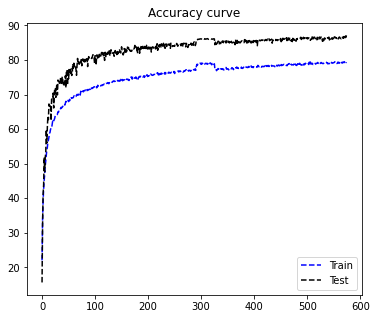

In [24]:
fig, ax1 = plt.subplots(1, 1, figsize=(6,5))
style = '--'

ax1.plot(train_acc, style, c='blue', label='Train')
ax1.plot(test_acc, style, c='black', label='Test')

ax1.title.set_text('Accuracy curve')

ax1.legend()

plt.savefig('./plots/metrics_87.png')